In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import *
import matplotlib
import plplot
from scipy import stats
#from io import StringIO
print(pd.__version__)
#AttributeError: 'Series' object has no attribute 'to_numpy'
import re

import math
import astropy as astro
import scipy.ndimage as spimage
from astropy.io import fits, ascii
from astropy.table import Table, join
from astropy.cosmology import WMAP9 as cosmo
import matplotlib as mpl
#from numpy import std as biweight_midvariance
import matplotlib.cm as cm

from scipy import optimize
from scipy.stats import gaussian_kde
from matplotlib import colors
import scipy.ndimage as ndimage
from collections import Counter
from matplotlib.legend import Legend
import matplotlib.patches as patches
from matplotlib import pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
#
#
#
import extinction


#
# seaborn
#
import pandas.util.testing as tm
import seaborn as sns

#
# Jorge
#

from sel2dhist_xy import sel2dhist_xy


#
# 3D plots!
#
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#biweight_midvariance
from scipy.stats import binned_statistic_2d
from scipy.ndimage.filters import gaussian_filter

import warnings
warnings.simplefilter("ignore")

#
# my_utils
#
from my_utils import *

#
#
#
from ndtest import *
from sklearn.decomposition import PCA

#
#
#
from scipy.optimize import leastsq, fmin
import matplotlib.animation as animation

#
# Carlos Color map
#
from cmaps_CLC import vel_map

from scipy.spatial import KDTree

1.1.1
1.1.1


<ipython-input-1-a87d685c6314>:41: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from matplotlib import rcParams as rc
rc.update({'font.size': 20,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 20,\
           'ytick.labelsize' : 20,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


['flux_Halpha_6562.85' 'vel_Halpha_6562.85' 'disp_Halpha_6562.85'
 'EW_Halpha_6562.85' 'e_flux_Halpha_6562.85' 'e_vel_Halpha_6562.85'
 'e_disp_Halpha_6562.85' 'e_EW_Halpha_6562.85']


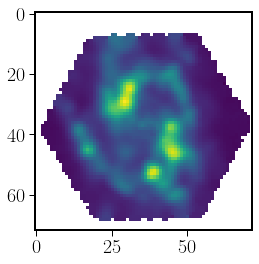

In [3]:
#maps=read_Pipe3D_MaNGA('manga-7495-12704',DIR='/disk-e/manga/data/v3_1_1/Pipe3D/',verbose=0)
maps=read_Pipe3D_MaNGA('manga-7495-12704',DIR='data',verbose=0)
al=np.array(list(maps['FEL'].keys()))
print(al[np.char.find(al,'Ha')>-1])

plt.imshow(maps['FEL']['flux_Halpha_6562.85'])

[0.04746599 0.42578249 0.90227699]


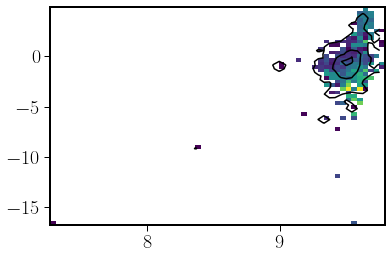

In [4]:
def den_map_TEST(x, y, z, bins=60, xLims=None, yLims=None, normValue=None, statistic='median',sigma=0.7):
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]
    
    if (xLims==None):
        xLims=[np.nanmin(x),np.nanmax(x)]
    if (yLims==None):
        yLims=[np.nanmin(y),np.nanmax(y)]

    counts, xbins, ybins = np.histogram2d(x, y, bins=bins,
                                              range=[xLims, yLims],
                                          normed=True)
    counts = gaussian_filter(counts, sigma)
    counts /= counts.max()
    mask_d = counts.transpose() == 0
    bin_means = binned_statistic_2d(x, y, z, bins=bins,
                                    range=[xLims, yLims],
                                    statistic=statistic).statistic
#    bin_means= gaussian_filter(bin_means, 0.5)
    if normValue is not None:
        bin_means /= normValue
        bin_means = np.abs(bin_means)
    dens_map = bin_means.T
    dens_map[mask_d] = np.nan
    output={}
    output['den']=counts
    output['xbins']=xbins
    output['ybins']=ybins
    output['val']=dens_map.T
    output['xLims']=xLims
    output['yLims']=yLims
    return output
    
#    return counts, xbins, ybins, dens_map.T, xLims, yLims
        
x_par=maps['SSP']['A_L']
y_par=maps['IND']['Mgb']        
z_par=maps['FEL']['flux_Halpha_6562.85']



#den_map = den_map(x_par,y_par,z_par,bins=60,xLims=[8,11],yLims=None,normValue=None)
den_map = get_den_map(x_par,y_par,z_par,bins=60)#,xLims=[8,11],yLims=None,normValue=None)

counts=den_map['den']
xbins=den_map['xbins']
ybins=den_map['ybins']
dens_map=den_map['val']
xLims=den_map['xLims']
yLims=den_map['yLims']

sum_total=np.nansum(counts)
vals=[]
levels=[]
for idx,cuts in enumerate(np.arange(0.00,1.0,0.01)):
    mask_now= counts>cuts
    levels.append(cuts)
    vals.append(np.nansum(counts[mask_now])/sum_total)
vals_cont=np.array([0.95,0.50,0.05])
levels_cont=np.interp(vals_cont,np.array(levels),np.array(vals))
print(levels_cont)
nbins=len(xbins)-1
plt.imshow(dens_map, origin='lower', aspect='auto', extent=xLims+yLims)
plt.contour(xbins[0:nbins],ybins[0:nbins],counts,levels_cont,colors='black')
#print(xbins)

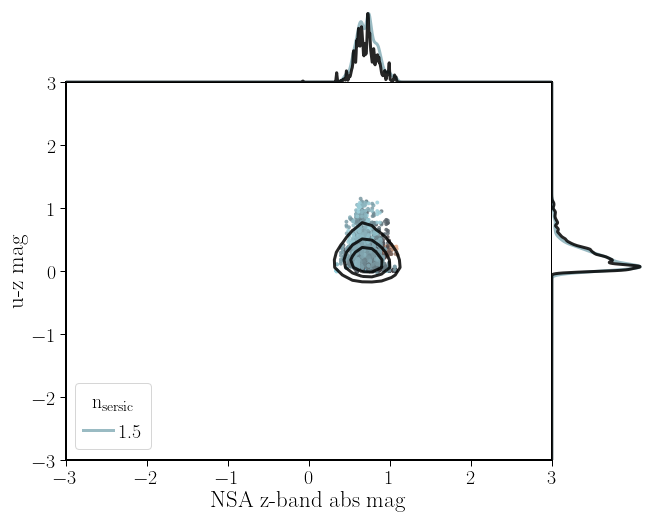

In [5]:
x_par=maps['SSP']['ML']
y_par=maps['FEL']['flux_Halpha_6562.85']
z_par=maps['IND']['D4000']
plot_2Dhist(x_par=x_par,y_par=y_par,z_par=z_par,\
            x_min=-3,x_max=3,y_min=-3,y_max=3,z_min=0,z_max=3,c_main='black',label='MPL-11',\
            x_label='NSA z-band abs mag',y_label='u-z mag',figname='CMD_nSersic',alpha=0.85,\
            size_scatter=5.0,n_zbins=7,z_lim=80,labels_zbins=None,color_cm_now=None,\
           z_label=r'n$_{\rm sersic}$')#'Spectral_r')

In [6]:
Pipe3D_tab,SSP_ML,SSP_ML_age,SSP_ML_met,SSP_lib_data,SSP_lib_hdr =  read_Pipe3D_MaNGA_table()
print(Pipe3D_tab)

       name       plate ifudsgn   plateifu  ...    Vmax_w    Num_w  QCFLAG
----------------- ----- ------- ----------- ... ----------- ------- ------
manga-10001-12701 10001   12701 10001-12701 ...  4.2211e-06 50.9497      0
manga-10001-12702 10001   12702 10001-12702 ...  3.7132e-06 44.8192      0
manga-10001-12703 10001   12703 10001-12703 ... 1.93554e-06 23.3624      0
manga-10001-12704 10001   12704 10001-12704 ... 1.68639e-06 20.3551      0
manga-10001-12705 10001   12705 10001-12705 ... 1.93554e-06 23.3624      0
 manga-10001-1901 10001    1901  10001-1901 ... 8.71277e-06 105.165      0
 manga-10001-1902 10001    1902  10001-1902 ...   7.905e-06 95.4153      0
 manga-10001-3701 10001    3701  10001-3701 ... 6.45567e-07 7.79216      0
 manga-10001-3702 10001    3702  10001-3702 ...  5.6706e-06 68.4455      0
 manga-10001-3703 10001    3703  10001-3703 ... 2.38905e-06 28.8364      0
              ...   ...     ...         ... ...         ...     ...    ...
  manga-9894-1902  9894  

In [7]:
Pipe3D_file="SDSS17Pipe3D_v3_1_1.fits"
DIR=''
Pipe3D_tab_hdu=fits.open(DIR+Pipe3D_file)
SSP_lib_data=Pipe3D_tab_hdu[2].data
SSP_lib_hdr=Pipe3D_tab_hdu[2].header
(ny,nx)=SSP_lib_data.shape
SSP_ML={}
SSP_ML_age={}
SSP_ML_met={}
a_age=[]
a_met=[]
a_age_met=[]
for i in arange(0,ny):
    key='NORM'+str(i)
    ssp_name='NAME'+str(i)
    ssp_file=SSP_lib_hdr[ssp_name]
    ssp_file=ssp_file.replace('spec_ssp_','')
    ssp_file=ssp_file.replace('.spec','')
    ssp_file=ssp_file.replace('z','')
    (age,met)=ssp_file.split('_')
    met='0.'+met
    age ='{:0.4f}'.format(float(age))
    met ='{:0.4f}'.format(float(met))
    age_met=age+'-'+met
    a_age_met.append(age_met)
    a_age.append(age)
    a_met.append(met)
    norm=(1/SSP_lib_hdr[key])/ 3500#*(1e-16)/3.826e33
    SSP_ML[age_met]=norm
    age_find = np.array(list(SSP_ML_age.keys()))
    if(len(age_find)==0):
        SSP_ML_age[age]=norm
    else:
        if (len(age_find[np.char.find(age_find,str(age))>-1])>0):
            SSP_ML_age[age]=SSP_ML_age[age]+norm
        else:
            SSP_ML_age[age]=norm   
    met_find = np.array(list(SSP_ML_met.keys()))
    if(len(met_find)==0):
        SSP_ML_met[met]=norm
    else:
        if (len(met_find[np.char.find(met_find,str(met))>-1])>0):
            SSP_ML_met[met]=SSP_ML_met[met]+norm
        else:
            SSP_ML_met[met]=norm  
    print(age,met,age_met,SSP_ML[age_met],SSP_ML_age[age],SSP_ML_met[met])

            
a_age_met=np.unique(a_age_met)
a_age=np.unique(a_age)
a_met=np.unique(a_met)
for age in a_age:
    SSP_ML_age[age]=SSP_ML_age[age]/len(a_met)
for met in a_met:
    SSP_ML_met[met]=SSP_ML_met[met]/len(a_age)

print(len(a_age_met),len(a_age),len(a_met))
print(len(SSP_ML_age),len(SSP_ML_met))

#    print(key,SSP_lib_hdr[ssp_name],norm)
Pipe3D_tab = Table.read(DIR+Pipe3D_file, hdu=1)
#print(SSP_lib_hdr)
#print(Pipe3D_tab)


0.0010 0.0001 0.0010-0.0001 0.07872868912796166 0.07872868912796166 0.07872868912796166
0.0010 0.0005 0.0010-0.0005 0.06541826805135334 0.144146957179315 0.06541826805135334
0.0010 0.0020 0.0010-0.0020 0.05815948493960137 0.20230644211891638 0.05815948493960137
0.0010 0.0080 0.0010-0.0080 0.0435506875564798 0.2458571296753962 0.0435506875564798
0.0010 0.0170 0.0010-0.0170 0.037349249093346984 0.28320637876874316 0.037349249093346984
0.0010 0.0300 0.0010-0.0300 0.03260796906155895 0.3158143478303021 0.03260796906155895
0.0010 0.0400 0.0010-0.0400 0.028844004413132677 0.3446583522434348 0.028844004413132677
0.0023 0.0001 0.0023-0.0001 0.060737289962859146 0.060737289962859146 0.1394659790908208
0.0023 0.0005 0.0023-0.0005 0.05097580433447264 0.11171309429733178 0.11639407238582597
0.0023 0.0020 0.0023-0.0020 0.04474843548282443 0.1564615297801562 0.1029079204224258
0.0023 0.0080 0.0023-0.0080 0.029731244416100658 0.18619277419625685 0.07328193197258046
0.0023 0.0170 0.0023-0.0170 0.02235

0.0900 0.0080 0.0900-0.0080 0.21908924600435986 0.9224413820985596 1.3237600799296052
0.0900 0.0170 0.0900-0.0170 0.2508245858259026 1.1732659679244621 1.3914000839926035
0.0900 0.0300 0.0900-0.0300 0.27359406848059536 1.4468600364050574 1.611669235139466
0.0900 0.0400 0.0900-0.0400 0.2768281035890764 1.7236881399941337 1.6604981109559374
0.1100 0.0001 0.1100-0.0001 0.2934888041358442 0.2934888041358442 2.29393490657253
0.1100 0.0005 0.1100-0.0005 0.24108875682582545 0.5345775609616696 1.7378935029130376
0.1100 0.0020 0.1100-0.0020 0.23947220326400612 0.7740497642256757 1.5032120459535236
0.1100 0.0080 0.1100-0.0080 0.24792978628452422 1.0219795505102 1.5716898662141294
0.1100 0.0170 0.1100-0.0170 0.28835853346617046 1.3103380839763705 1.679758617458774
0.1100 0.0300 0.1100-0.0300 0.30523073917728105 1.6155688231536516 1.916899974316747
0.1100 0.0400 0.1100-0.0400 0.30874346042757883 1.9243122835812305 1.9692415713835163
0.1400 0.0001 0.1400-0.0001 0.327657754921829 0.327657754921829 2

2.0000 0.0020 2.0000-0.0020 1.95040129506646 5.400992664808415 11.938940490359137
2.0000 0.0080 2.0000-0.0080 2.5432996770009413 7.944292341809357 14.078851845148352
2.0000 0.0170 2.0000-0.0170 3.046709097168693 10.99100143897805 16.425385368066497
2.0000 0.0300 2.0000-0.0300 3.58487184083169 14.57587327980974 18.976642481174018
2.0000 0.0400 2.0000-0.0400 3.7880581466925514 18.36393142650229 20.44681872816893
2.5000 0.0001 2.5000-0.0001 1.9460174752369275 1.9460174752369275 14.862970727175416
2.5000 0.0005 2.5000-0.0005 2.050630056084732 3.9966475313216594 13.927708617769643
2.5000 0.0020 2.5000-0.0020 2.3608848596453953 6.357532390967055 14.299825350004532
2.5000 0.0080 2.5000-0.0080 3.247712798261824 9.60524518922888 17.326564643410176
2.5000 0.0170 2.5000-0.0170 3.950804581352993 13.556049770581872 20.37618994941949
2.5000 0.0300 2.5000-0.0300 4.859169130670346 18.415218901252217 23.835811611844363
2.5000 0.0400 2.5000-0.0400 5.132376829371566 23.547595730623783 25.579195557540498


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



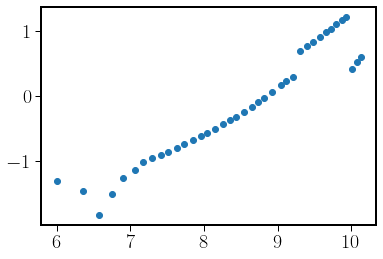

In [8]:
#print(len(a_age))
#print(list(SSP_ML_age.values()))
plt.scatter(9+np.log10(a_age.astype('float')),np.log10(np.array(list(SSP_ML_age.values()))))


READING TABLES

In [9]:
#
# Reading get_proc_elines table!
# 
get_proc_elines="tables/get_proc_elines_MaNGA.clean.csv"
col_proc_elines=header_columns(get_proc_elines,2)
tab_pe=ascii.read(get_proc_elines, delimiter=',', guess=True, comment='\s*#', names=col_proc_elines,\
                      fill_values=[('BAD', np.nan)])
list_columns(tab_pe.columns)

MaNGA_name                          log_Mass_gas                        e_OH_Re_fit_dop                     ZH_T50                              
nsa_redshift                        log_Mass_gas_Re                     alpha_OH_Re_fit_dop                 ZH_Re_T50                           
nsa_u_absmag                        log_Mass_gas_Av_ssp_ZH              e_alpha_OH_Re_fit_dop               a_ZH_T50                            
nsa_z_absmag                        log_Mass_gas_Av_ssp                 cc_r_OH_dop                         T60                                 
nsa_u_z_absmag                      log_Mass_gas_Av_gas_rad             sig_r_OH_dop                        ZH_T60                              
nsa_mstar                           log_Mass_stars_sigma                NO_Re_fit_EPM09                     ZH_Re_T60                           
nsa_inclination                     log_F_Ha                            e_NO_Re_fit_EPM09                   a_ZH_T60              

elip_ab                             OH_Re_fit_dop                       T501                                                                    


In [10]:
#
# Reading Mag table
#
get_mag_cubes="tables/get_mag_cubes_v3_1_1_redshift.csv"
col_mag_cubes=header_columns_space(get_mag_cubes,2)
tab_mag=ascii.read(get_mag_cubes, delimiter=',', guess=True, comment='\s*#', names=col_mag_cubes,\
                      fill_values=[('BAD', np.nan)])
#print(tab_pe)
tab_mag.rename_column('name-obj', 'name')
list_columns(col_mag_cubes)


name-obj                   i_band_mag_error           Y_centroid                 SN_at_R50                  
redshift                   i_band_abs_mag             Re                         error_SN_at_R50            
error_redshift             i_band_abs_mag_error       error_Re                   Re1                        
u_band_mag                 B_band_mag                 mean_S/N_at_Re             error_Re1                  
u_band_mag_error           B_band_mag_error           sigma_S/N_at_Re            B-V                        
u_band_abs_mag             B_band_abs_mag             ellipticy                  error_B-V                  
u_band_abs_mag_error       B_band_abs_mag_error       Pa                         B-R                        
g_band_mag                 V_band_mag                 R50                        error_B-R                  
g_band_mag_error           V_band_mag_error           error_R50                  log10_Mass/Msun_phot.      
g_band_abs_mag     

In [11]:
#
# Reading Indices at Re
#
get_ind_Re="tables/get_val_ind_Re_MaNGA.csv"
col_ind_Re=header_columns_space(get_ind_Re,2)
tab_ind_Re=ascii.read(get_ind_Re, delimiter=',', guess=True, comment='\s*#', names=col_ind_Re,\
                      fill_values=[('BAD', np.nan)])
#print(tab_ind_Re)
tab_ind_Re.rename_column('MaNGA_name', 'name')
list_columns(tab_ind_Re.columns)


name        Mgb         e_Fe5335    Hg          
Hd          e_Mgb       e4000       e_Hg        
e_Hd        Fe5270      e_e4000     SN          
Hb          e_Fe5270    Hdmod       e_SN        
e_Hb        Fe5335      e_Hdmod                 


In [12]:
#
# Reading Indices at Re
#
get_ind="tables/get_proc_indices_MaNGA.clean.csv"
col_ind=header_columns_space(get_ind,2)
tab_ind=ascii.read(get_ind, delimiter=',', guess=True, comment='\s*#', names=col_ind,\
                      fill_values=[('BAD', np.nan)])
#print(tab_ind_Re)
#tab_ind_Re.rename_column('MaNGA_name', 'name')
list_columns(tab_ind.columns)


MaNGA_name            e_D4000_fit           e_Hb_Re_fit           e_D4000_Re_fit        
nsa_redshift          slope_D4000           Hb_alpha_fit          D4000_alpha_fit       
nsa_u_absmag          e_slope_D4000         e_Hb_alpha_fit        e_D4000_alpha_fit     
nsa_z_absmag          D4000_OH_fit          Mgb_Re_fit            Hdmod_Re_fit          
nsa_u_z_absmag        e_D4000_fit1          e_Mgb_Re_fit          e_Hdmod_Re_fit        
nsa_mstar             slope_D4000_OH        Mgb_alpha_fit         Hdmod_alpha_fit       
nsa_inclination       e_slope_D4000_OH      e_Mgb_alpha_fit       e_Hdmod_alpha_fit     
nsa_petro_th50        Sgas_OH_fit           Fe5270_Re_fit         Hg_Re_fit             
nsa_sersic_ba         e_Sgas_fit            e_Fe5270_Re_fit       e_Hg_Re_fit           
nsa_sersic_n          slope_Sgas_OH         Fe5270_alpha_fit      Hg_alpha_fit          
nsa_sersic_phi        e_slope_Sgas          e_Fe5270_alpha_fit    e_Hg_alpha_fit        
nsa_sersic_th50      

In [13]:
#
# Reading Indices at Re
#
get_Re="tables/get_val_Re_MaNGA.csv"
col_Re=header_columns_space(get_Re,2)
tab_val_Re=ascii.read(get_Re, delimiter=',', guess=True, comment='\s*#', names=col_Re,\
                      fill_values=[('BAD', np.nan)])
#print(tab_ind_Re)
tab_val_Re.rename_column('MaNGA_name', 'name')
list_columns(tab_val_Re.columns)


name                    e_Age_LW                e_disp_Ha               e_ML                    
Sigma_Mass_stars        Age_MW                  vel_Ha                  Sigma_SFR_ssp           
e_Sigma_Mass_stars      e_Age_MW                e_vel_Ha                e_Sigma_SFR_ssp         
Sigma_SFR               OH_t2                   vel_ssp                 Sigma_Mass_gas_rad      
e_Sigma_SFR             e_OH_t2                 e_vel_ssp               e_Sigma_Mass_gas_rad    
Sigma_Mass_gas          OH_O3N2                 SK_ssp                  Lambda                  
e_Sigma_Mass_gas        e_OH_O3N2               e_SK_ssp                e_Lambda                
Sigma_Mass_gas_ssp      Av_gas                  SK_Ha                   OH_ONS                  
e_Sigma_Mass_gas_ssp    e_Av_gas                e_SK_Ha                 e_OH_ONS                
ZH_LW                   Av_ssp                  KIN_ssp                 NO_ONS                  
e_ZH_LW                 e_Av_s

In [14]:
#
# Reading Indices at Re
#
get_in_Re="tables/get_val_within_Re_MaNGA.csv"
col_in_Re=header_columns_space(get_in_Re,2)
tab_val_in_Re=ascii.read(get_in_Re, delimiter=',', guess=True, comment='\s*#', names=col_in_Re,\
                      fill_values=[('BAD', np.nan)])
list_col_names=tab_val_in_Re.columns.copy()
for col_name in list_col_names:
    new_col_name="in_"+col_name
    tab_val_in_Re.rename_column(col_name, new_col_name)
#print(tab_ind_Re)
tab_val_in_Re.rename_column('in_MaNGA_name', 'name')
list_columns(tab_val_in_Re.columns)


name                       in_e_Age_LW                in_e_disp_Ha               in_e_ML                    
in_Sigma_Mass_stars        in_Age_MW                  in_vel_Ha                  in_Sigma_SFR_ssp           
in_e_Sigma_Mass_stars      in_e_Age_MW                in_e_vel_Ha                in_e_Sigma_SFR_ssp         
in_Sigma_SFR               in_OH_t2                   in_vel_ssp                 in_Sigma_Mass_gas_rad      
in_e_Sigma_SFR             in_e_OH_t2                 in_e_vel_ssp               in_e_Sigma_Mass_gas_rad    
in_Sigma_Mass_gas          in_OH_O3N2                 in_SK_ssp                  in_Lambda                  
in_e_Sigma_Mass_gas        in_e_OH_O3N2               in_e_SK_ssp                in_e_Lambda                
in_Sigma_Mass_gas_ssp      in_Av_gas                  in_SK_Ha                   in_OH_ONS                  
in_e_Sigma_Mass_gas_ssp    in_e_Av_gas                in_e_SK_Ha                 in_e_OH_ONS                
in_ZH_LW           

In [15]:
#
# Reading flux_elines_table
#
get_p_fe="tables/get_proc_flux_elines_MaNGA.clean.csv"
col_p_fe=header_columns_space(get_p_fe,2)
tab_fe=ascii.read(get_p_fe, delimiter=',', guess=True, comment='\s*#', names=col_p_fe,\
                      fill_values=[('BAD', np.nan)])
print(len(tab_fe))
list_columns(tab_fe.columns)


#tab_mag.rename_column('name-obj', 'name')

10154
MaNGA_name                          e_flux_HI3889.05_alpha_fit          e_flux_[OIII]5006.84_alpha_fit      e_flux_Halpha6562.85_alpha_fit      
nsa_redshift                        flux_HeI3964.73_Re_fit              flux_HeI5015.68_Re_fit              flux_[NII]6583.45_Re_fit            
nsa_u_absmag                        e_flux_HeI3964.73_Re_fit            e_flux_HeI5015.68_Re_fit            e_flux_[NII]6583.45_Re_fit          
nsa_z_absmag                        flux_HeI3964.73_alpha_fit           flux_HeI5015.68_alpha_fit           flux_[NII]6583.45_alpha_fit         
nsa_u_z_absmag                      e_flux_HeI3964.73_alpha_fit         e_flux_HeI5015.68_alpha_fit         e_flux_[NII]6583.45_alpha_fit       
nsa_mstar                           flux_[NeIII]3967.46_Re_fit          flux_[NI]5197.9_Re_fit              flux_[SII]6716.44_Re_fit            
nsa_inclination                     e_flux_[NeIII]3967.46_Re_fit        e_flux_[NI]5197.9_Re_fit            e_flux_[SII]6716

In [16]:
#
# Reading flux_elines_table
#
get_p_fe_org="tables/get_proc_flux_elines_org_MaNGA.clean.csv"
col_p_fe_org=header_columns_space(get_p_fe_org,2)
tab_fe_org=ascii.read(get_p_fe_org, delimiter=',', guess=True, comment='\s*#', names=col_p_fe_org,\
                      fill_values=[('BAD', np.nan)])
#print(tab_pe)
#tab_mag.rename_column('name-obj', 'name')
#list_columns(col_p_fe_org)
print(len(tab_fe_org))
list_columns(tab_fe_org.columns)


#tab_mag.rename_column('name-obj', 'name')

10156
MaNGA_name                           EW_[SII]4076_Re_fit                  e_disp_[OIII]4958_Re_fit             l_flux_[SIII]6312_Ha_alpha_fit       
nsa_redshift                         e_EW_[SII]4076_Re_fit                disp_[OIII]4958_alpha_fit            e_l_flux_[SIII]6312_Ha_alpha_fit     
nsa_u_absmag                         EW_[SII]4076_alpha_fit               e_disp_[OIII]4958_alpha_fit          l_flux_SiII6347_Ha_Re_fit            
nsa_z_absmag                         e_EW_[SII]4076_alpha_fit             disp_Hb4861_Re_fit                   e_l_flux_SiII6347_Ha_Re_fit          
nsa_u_z_absmag                       EW_Hd4101_Re_fit                     e_disp_Hb4861_Re_fit                 l_flux_SiII6347_Ha_alpha_fit         
nsa_mstar                            e_EW_Hd4101_Re_fit                   disp_Hb4861_alpha_fit                e_l_flux_SiII6347_Ha_alpha_fit       
nsa_inclination                      EW_Hd4101_alpha_fit                  e_disp_Hb4861_alpha_fit   

e_EW_[SII]4069_alpha_fit             disp_[OIII]4958_Re_fit               e_l_flux_[SIII]6312_Ha_Re_fit                                             


In [17]:
#
# Reading flux_elines_table
#
get_p_OH="tables/get_proc_OH_MaNGA.clean.csv"
col_p_OH=header_columns_space(get_p_OH,2)
tab_OH=ascii.read(get_p_OH, delimiter=',', guess=True, comment='\s*#', names=col_p_OH,\
                      fill_values=[('BAD', np.nan)])
#print(tab_pe)
#tab_mag.rename_column('name-obj', 'name')
#list_columns(col_p_fe_org)
print(len(tab_OH))
list_columns(tab_OH.columns)


#tab_mag.rename_column('name-obj', 'name')

10243
MaNGA_name                      e_OH_Pet04_O3N2_alpha_fit       e_OH_Cur20_R2_alpha_fit         e_U_Dors_O32_alpha_fit          
nsa_redshift                    OH_Kew02_N2O2_Re_fit            OH_Cur20_N2_Re_fit              U_Dors_S_Re_fit                 
nsa_u_absmag                    e_OH_Kew02_N2O2_Re_fit          e_OH_Cur20_N2_Re_fit            e_U_Dors_S_Re_fit               
nsa_z_absmag                    OH_Kew02_N2O2_alpha_fit         OH_Cur20_N2_alpha_fit           U_Dors_S_alpha_fit              
nsa_u_z_absmag                  e_OH_Kew02_N2O2_alpha_fit       e_OH_Cur20_N2_alpha_fit         e_U_Dors_S_alpha_fit            
nsa_mstar                       OH_Pil10_ONS_Re_fit             OH_Cur20_R23_Re_fit             U_Mor16_O23_fs_Re_fit           
nsa_inclination                 e_OH_Pil10_ONS_Re_fit           e_OH_Cur20_R23_Re_fit           e_U_Mor16_O23_fs_Re_fit         
nsa_petro_th50                  OH_Pil10_ONS_alpha_fit          OH_Cur20_R23_alpha_fit     

In [18]:
#
# Reading morphological table
#
#morph={'-2':'CD','-1':'E','0':'S0','1':'Sa','2':'Sab','3':'Sb','4':'Sbc','5':'Sc','6':'Scd',\
#       '7':'Sd','8':'Sdm','9':'Sm','10':'Irr'}
morph={-2:'CD',-1:'E',0:'S0',1:'Sa',2:'Sab',3:'Sb',4:'Sbc',5:'Sc',6:'Scd',\
       7:'Sd',8:'Sdm',9:'Sm',10:'Irr'}
morph_file="tables/manga-morphall-v3_1_1.fits"
tab_morph = Table.read(morph_file, format='fits')
tab_morph.rename_column('index', 'name')
tab_morph.rename_column('nsa_sersic_n', 'nsa_sersic_n_morph')
list_columns(tab_morph.columns)
print(morph)


name                  r-i                   P(Sab)                P(Sm)                 
nsa_sersic_n_morph    i-z                   P(Sb)                 P(Irr)                
log_Mass_corr         C (R50/R90)           P(Sbc)                best type_n           
rat_vel_sigma         P(CD)                 P(Sc)                 best type             
Ellipticity           P(E)                  P(Scd)                                      
u-g                   P(S0)                 P(Sd)                                       
g-r                   P(Sa)                 P(Sdm)                                      
{-2: 'CD', -1: 'E', 0: 'S0', 1: 'Sa', 2: 'Sab', 3: 'Sb', 4: 'Sbc', 5: 'Sc', 6: 'Scd', 7: 'Sd', 8: 'Sdm', 9: 'Sm', 10: 'Irr'}


In [19]:
drpall='tables/drpall-v3_1_1.fits'
tab_dr = Table.read(drpall, format='fits')
tab_dr['name']=tab_dr['plateifu']
for indx,val in enumerate(tab_dr['name']):
    tab_dr['name'][indx]='manga-'+tab_dr['name'][indx]
list_columns(tab_dr.columns)
print(tab_dr['name'])

plate                    cartid                   manga_tileid             nsa_nsaid                
ifudsgn                  designid                 nsa_iauname              nsa_nsaid_v1b            
plateifu                 cenra                    ifudesignsize            nsa_z                    
mangaid                  cendec                   ifutargetsize            nsa_zdist                
versdrp2                 airmsmin                 ifudesignwrongsize       nsa_sersic_absmag        
versdrp3                 airmsmed                 z                        nsa_elpetro_absmag       
verscore                 airmsmax                 zmin                     nsa_elpetro_amivar       
versutil                 seemin                   zmax                     nsa_sersic_mass          
versprim                 seemed                   szmin                    nsa_elpetro_mass         
platetyp                 seemax                   szmax                    nsa_elpetro_ba  

In [20]:
vol_file="tables/MaNGA_MPL11_Volume_C.fits"
tab_vol = Table.read(vol_file, format='fits')
tab_vol['name']=tab_vol['plateifu']
for indx,val in enumerate(tab_vol['name']):
    name_now='manga-'+tab_vol['name'][indx]
    name_now=name_now.replace(" ","")
    tab_vol['name'][indx]=name_now
    

print(tab_vol['name'],tab_vol['Vmax_w'])
list_columns(tab_vol.columns)


       name      
-----------------
manga-10001-12701
manga-10001-12702
manga-10001-12703
manga-10001-12704
manga-10001-12705
 manga-10001-1901
 manga-10001-1902
 manga-10001-3701
 manga-10001-3702
 manga-10001-3703
              ...
 manga-9894-12705
  manga-9894-1902
  manga-9894-3701
  manga-9894-3703
  manga-9894-3704
  manga-9894-6101
  manga-9894-6102
  manga-9894-6103
  manga-9894-6104
  manga-9894-9101
  manga-9894-9102
Length = 9341 rows    Vmax_w  
-----------
 4.2211e-06
 3.7132e-06
1.93554e-06
1.68639e-06
1.93554e-06
8.71277e-06
  7.905e-06
6.45567e-07
 5.6706e-06
2.38905e-06
        ...
7.56699e-06
1.13259e-05
4.09177e-06
 2.7185e-06
7.29204e-07
1.66874e-06
1.26995e-05
1.26995e-05
2.05023e-06
 8.6621e-08
8.28911e-06
Length = 9341 rows
plate        mangaid      logMs_nsa    Num_w        
ifudsgn      nsa_nsaid    z_obs_nsa    name         
plateifu     nsaid        Vmax_w                    


In [21]:
#
# Joininig all tables
#
tab_mag['u-i']=tab_mag['u_band_mag']-tab_mag['i_band_mag']
tab_all=join(tab_pe,tab_mag,keys=['name'],join_type='left')
print("get_proc and get_mag joint")
tab_all=join(tab_all,tab_morph,keys=['name'],join_type='left')
print("... morph added")
tab_all=join(tab_all,tab_dr,keys=['name'],join_type='left')
print("... DR added")
tab_fe.remove_columns(['MaNGA_name','nsa_petro_th50', 'nsa_sersic_ba', 'nsa_sersic_n',\
                       'nsa_sersic_phi','nsa_sersic_th50'])
tab_all=join(tab_all,tab_fe,keys=['name'],join_type='left')
print("... flux_elines_long added")
tab_fe_org.remove_columns(['MaNGA_name','nsa_petro_th50', 'nsa_sersic_ba', 'nsa_sersic_n',\
                           'nsa_sersic_phi','nsa_sersic_th50'])
tab_all=join(tab_all,tab_fe_org,keys=['name'],join_type='left')
print("... flux_elines org added")
tab_OH.remove_columns(['MaNGA_name','nsa_petro_th50', 'nsa_sersic_ba', 'nsa_sersic_n',\
                       'nsa_sersic_phi','nsa_sersic_th50','nsa_redshift', 'nsa_u_absmag',\
                       'nsa_z_absmag', 'nsa_u_z_absmag', 'nsa_mstar', 'nsa_inclination'])
tab_all=join(tab_all,tab_OH,keys=['name'],join_type='left')
print("... OH added")
tab_all=join(tab_all,tab_ind_Re,keys=['name'],join_type='left')
print("... Indices at Re added")
tab_ind.remove_columns(['MaNGA_name','nsa_petro_th50', 'nsa_sersic_ba', 'nsa_sersic_n',\
                       'nsa_sersic_phi','nsa_sersic_th50','nsa_redshift', 'nsa_u_absmag',\
                       'nsa_z_absmag', 'nsa_u_z_absmag', 'nsa_mstar', 'nsa_inclination'])
tab_all=join(tab_all,tab_ind,keys=['name'],join_type='left')
print("... Indices fitted added")
tab_all=join(tab_all,tab_val_Re,keys=['name'],join_type='left')
print("... Values at Re added")
tab_all=join(tab_all,tab_val_in_Re,keys=['name'],join_type='left')
print("... Values in Re added")
tab_all=join(tab_all,tab_vol,keys=['name'],join_type='right')    
print("... Values of volume added")
#tab_all([data[n].filled(np.nan) for n in data.colnames])


get_proc and get_mag joint
... morph added
... DR added
... flux_elines_long added
... flux_elines org added
... OH added
... Indices at Re added
... Indices fitted added
... Values at Re added
... Values in Re added
... Values of volume added


In [22]:
print(tab_all['Vmax_w'])
#for name in tab_vol['name']:
#    print("|"+name+"|")
#    print(name)
#    print(tab_vol['name'][tab_vol['name']==name])
#tab_all_vol=join(tab_all,tab_vol,keys=['name'],join_type='right')    
#print("... Values of volume added")
#print(tab_all_vol['Vmax_w'])

   Vmax_w  
-----------
 4.2211e-06
 3.7132e-06
1.93554e-06
1.68639e-06
1.93554e-06
8.71277e-06
  7.905e-06
6.45567e-07
 5.6706e-06
2.38905e-06
        ...
7.56699e-06
1.13259e-05
4.09177e-06
 2.7185e-06
7.29204e-07
1.66874e-06
1.26995e-05
1.26995e-05
2.05023e-06
 8.6621e-08
8.28911e-06
Length = 9348 rows


In [23]:
list_columns(tab_all.columns,5)

MaNGA_name                           a_ZH_T99                             flux_H83889_Re_fit                   disp_[SII]4076_Re_fit                l_flux_Hg4340_Hb_Re_fit              
nsa_redshift_1                       log_Mass_gas_Av_gas_OH               e_flux_H83889_Re_fit                 e_disp_[SII]4076_Re_fit              e_l_flux_Hg4340_Hb_Re_fit            
nsa_u_absmag_1                       log_Mass_gas_Av_ssp_OH               flux_H83889_alpha_fit                disp_[SII]4076_alpha_fit             l_flux_Hg4340_Hb_alpha_fit           
nsa_z_absmag_1                       lSFR_NO_CEN                          e_flux_H83889_alpha_fit              e_disp_[SII]4076_alpha_fit           e_l_flux_Hg4340_Hb_alpha_fit         
nsa_u_z_absmag_1                     vel_ssp_2                            flux_[NeIII]3967_Re_fit              disp_Hd4101_Re_fit                   l_flux_[OIII]4363_Hb_Re_fit          
nsa_mstar_1                          e_vel_ssp_2                      

ZH_Re_T99                            e_flux_[NeIII]3869_alpha_fit         e_disp_[SII]4069_alpha_fit           e_l_flux_[FeII]4319_Hb_alpha_fit                                          


In [24]:
print(len(tab_all.columns))

2378


In [25]:
#
# Defining some new variables
#
tab_all['Fe']=np.sqrt(tab_all['Fe5270']*tab_all['Fe5335'])
tab_all['OZ_Ho']=tab_all['OH_Ho_Re_fit']-8.67-tab_all['ZH_LW_Re']
tab_all['Mg_Fe']=np.log10(tab_all['Mgb']/tab_all['Fe'])
tab_all['FUV-z']=tab_all['nsa_elpetro_absmag'][:,0]-tab_all['nsa_elpetro_absmag'][:,6]
tab_all['z abs']=tab_all['nsa_elpetro_absmag'][:,6]
tab_all['NUV-z']=tab_all['nsa_elpetro_absmag'][:,1]-tab_all['nsa_elpetro_absmag'][:,6]
tab_all['u-z']=tab_all['nsa_elpetro_absmag'][:,2]-tab_all['nsa_elpetro_absmag'][:,6]
tab_all['u-i nsa']=tab_all['nsa_elpetro_absmag'][:,2]-tab_all['nsa_elpetro_absmag'][:,5]
tab_all['FUV-i']=tab_all['nsa_elpetro_absmag'][:,0]-tab_all['nsa_elpetro_absmag'][:,5]
tab_all['i_abs']=tab_all['nsa_elpetro_absmag'][:,5]
print(tab_all['nsa_elpetro_absmag'][0])
#print(tab_all['nsa_elpetro_absmag'][:,0])
#tab_all.rename_column('z_abs','z abs')
print(np.nanmean(tab_all['z abs']))


[-16.2321 -16.7716 -17.9054 -18.7874 -19.2112 -19.3438 -19.5522]
-20.592547352487138


In [26]:
def my_contour(ax,x_cont,y_cont,x_min,x_max,y_min,y_max,c_color='red', title='', nbins=30, zorder=1, linewidths=2,alpha=0.75):
    N_min=2
    Delta=0.3
#    nbins=30
    mask_cont = (x_cont>x_min) & (x_cont<x_max) & (y_cont>y_min) & (y_cont<y_max)  
    x_plt, y_plt = x_cont[mask_cont], y_cont[mask_cont]
    counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=nbins,
        normed=True,range=[[x_min,x_max],[y_min,y_max]])
    counts=ndimage.gaussian_filter(counts, sigma=1, order=0)
    counts /= counts.max()
    sum_total=counts.sum()
    vals=[]
    levels=[]
    for idx,cuts in enumerate(np.arange(0.00,1.0,0.01)):
        mask_now= counts>cuts
        levels.append(cuts)
        vals.append(counts[mask_now].sum()/sum_total)
    vals_cont=np.array([0.95,0.65,0.40])
    levels_cont=np.interp(vals_cont,np.array(levels),np.array(vals))
    counts_rot=np.rot90(counts,3)
    xbins=xbins+0.5*(x_max-x_min)/nbins
    ybins=ybins+0.5*(y_max-y_min)/nbins
    flip_counts_rot=np.fliplr(counts_rot)
    p_cont=ax.contour(xbins[0:nbins],ybins[0:nbins],flip_counts_rot,levels_cont,\
                      colors=c_color,alpha=alpha,linewidths=linewidths,zorder=zorder)
#    labels = ['Div Neg', 'Div Pos', 'Rot Neg', 'Rot Pos']
    if (len(title)>0):
        p_cont.collections[0].set_label(title)
    #    h_cont,l_cont = p_cont.legend_elements(title)
#    ax.legend(h_cont, l_cont)

def biweight_midvariance(par):
    val=np.nanstd(par)/np.sqrt(2)
    return val

def my_scatter(ax,x_par,y_par,c_par,x_cont,y_cont,x_min,x_max,y_min,y_max,c_min,c_max,x_label,y_label,xf_min=0.0,yf_min=0.0,den_par_min=0.85,bin_size=0.3,bin_number=2,c_color="black",c_color2="darksalmon",error=0.05,MC=10, Delta=0.15):
    cm = califa_vel_r
    if (xf_min==0.0):
        xf_min=x_min
    if (yf_min==0.0):
        yf_min=y_min
#    MC=5
#    error=0.05
    N_min=2
#    Delta=0.15
#    den_par_min=0.9
    nbins=30
    lEW_cut=0.78 #0.78
    n_obj_org=len(x_par)
#    print("# N.OBJ = ",n_obj_org)
#    mask = (x_par>x_min) & (x_par<x_max) & (y_par>y_min) & (y_par<y_max)  
    mask = x_par>-20
    n_obj=len(x_par[mask])
#    print(x_par[~mask])
#    print("# N.Obj = ",n_obj,x_min,x_max,y_min,y_max)
    mask_SFGs = mask & (c_par>lEW_cut)
    mask_cont = (x_cont>x_min) & (x_cont<x_max) & (y_cont>y_min) & (y_cont<y_max)  
#
# Density to plot!
#
    x_plt, y_plt = x_cont[mask_cont], y_cont[mask_cont]
#    nbins=40
    counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=nbins,
        normed=True,range=[[x_min,x_max],[y_min,y_max]])
#        range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
                                            #    counts /= counts.max()

    counts=ndimage.gaussian_filter(counts, sigma=1, order=0)
    counts /= counts.max()
    sum_total=counts.sum()
    vals=[]
    levels=[]
    for idx,cuts in enumerate(np.arange(0.00,1.0,0.01)):
        mask_now= counts>cuts
        levels.append(cuts)
        vals.append(counts[mask_now].sum()/sum_total)
        #print(idx,levels[idx],vals[idx])
    vals_cont=np.array([0.95,0.80,0.40])
    levels_cont=np.interp(vals_cont,np.array(levels),np.array(vals))
    figure=ax.scatter(x_par, y_par, c=c_par, vmin=c_min,vmax=c_max,alpha=0.4,edgecolor='none',\
                      rasterized=True,cmap=cm)
    counts_rot=np.rot90(counts,3)
    xbins=xbins+0.5*(x_max-x_min)/nbins
    ybins=ybins+0.5*(y_max-y_min)/nbins
    flip_counts_rot=np.fliplr(counts_rot)
    p_cont=ax.contour(xbins[0:nbins],ybins[0:nbins],flip_counts_rot,levels_cont,colors=c_color)

    #
    # Density near a point
    #
    x_plt, y_plt = x_par[mask_SFGs], y_par[mask_SFGs]
    n_sf=len(x_par[mask_SFGs])
    #    nbins=40
    counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=nbins,
        normed=True,
        range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
                                            #    counts /= counts.max()
#    print(xbins,ybins)
    counts=ndimage.gaussian_filter(counts, sigma=1, order=0)
    counts /= counts.max()
    sum_total=counts.sum()
    vals_new=[]
    levels_new=[]
    for idx,cuts in enumerate(np.arange(0.00,1.0,0.01)):
        mask_now= counts>cuts
        levels_new.append(cuts)
        vals_new.append(counts[mask_now].sum()/sum_total)
        #print(idx,levels[idx],vals[idx])
    vals_cont=np.array([0.95,0.80,0.40])
    levels_cont=np.interp(vals_cont,np.array(levels_new),np.array(vals))
    
#    figure=ax.scatter(x_par, y_par, c=c_par, vmin=c_min,vmax=c_max,alpha=0.4,edgecolor='none',cmap=cm)
    counts_rot=np.rot90(counts,3)
    xbins=xbins+0.5*(x_max-x_min)/nbins
    ybins=ybins+0.5*(y_max-y_min)/nbins
    flip_counts_rot=np.fliplr(counts_rot)
    
  
    den_par=np.zeros(len(x_par))
    for i in range(len(x_par)):
        if ((np.isfinite(x_par[i])) and (np.isfinite(y_par[i]))):
            i_x=np.argmin(np.abs(xbins-x_par[i]))
            i_y=np.argmin(np.abs(ybins-y_par[i]))
            if ((i_x>0) and (i_x<nbins) and (i_y>0) and (i_y<nbins)):
                den_par[i]=np.interp(counts[i_x,i_y],np.array(levels_new),np.array(vals_new))

# Density plot!
#    figure=ax.scatter(x_par, y_par, c=den_par, vmin=0,vmax=1,alpha=0.4,edgecolor='none',cmap=cm)
    p_cont2=ax.contour(xbins[0:nbins],ybins[0:nbins],flip_counts_rot,levels_cont,colors=c_color2)
#
# We mask low density points
#
#    print("# den_par_min=",den_par_min)
    mask_SFGs = mask_SFGs & (den_par<den_par_min) & \
    np.logical_not(np.isnan(x_par)) & np.isfinite(x_par) & \
    np.logical_not(np.isnan(y_par)) & np.isfinite(y_par)  

    x_sf=x_par[mask_SFGs]
    y_sf=y_par[mask_SFGs]
    
#    figure=ax.scatter(x_par, y_par, c=den_par, vmin=0,vmax=1,alpha=0.4,edgecolor='none',cmap=cm)
    
    bin1 , min1 , max1= Delta,x_min,x_max
    m1, sM1, sD1 = binning_M(x_sf, y_sf, bin1 , min1 , max1, N_min, bin_size, bin_number )
    p1 = ax.errorbar(m1, sM1, yerr= sD1, markersize = 9, markerfacecolor =c_color2, markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = '', zorder=2, alpha=0.7)


#    x_sf=x_par[mask_SFGs]
#    y_sf=y_par[mask_SFGs]
    bin1 , min1 , max1= Delta,xf_min,x_max
    funct    = lambda x,a,b: a + b * x
    START=[-1,1.0]
    pa1=np.zeros(2)
    ea1=np.zeros(2)
#    print('#vals to fit =',m1,sM1,sD1)
    if m1.size > 2:
        m1, sM1, sD1 = binning_M(x_sf, y_sf, bin1 , min1 , max1, N_min, 0.3,2 )
        mean_sD1=np.nanmean(sD1)
        sD1=sD1+mean_sD1
        np.clip(sD1,0.5*mean_sD1,1.5*mean_sD1)
        pa1, ea1  = optimize.curve_fit(funct, m1, sM1, sigma=np.sqrt(sD1), p0 = START )
        a_pa=np.zeros((MC,2))
        a_ea=np.zeros((MC,2,2))
        a_rc=np.zeros((MC,2,2))
        for iMC in range(MC):
            e_x_sf=np.abs(2*error-error*(x_sf-x_min)/(x_max-x_min))
            e_y_sf=np.abs(2*error-error*(y_sf-y_min)/(y_max-y_min))
            
#            print('e_y=',e_y_sf,len(e_y_sf))
#            print('e-x=',e_x_sf,len(e_x_sf))
            x_sf_now=x_sf+np.random.normal(loc=0.0,scale=e_x_sf,size=len(e_x_sf))
            y_sf_now=y_sf+np.random.normal(loc=0.0,scale=e_y_sf,size=len(e_y_sf))
            mNOW, sMNOW, sDNOW = binning_M(x_sf_now, y_sf_now, bin1 , min1 , max1, N_min, 0.3,2 )
            rcNOW=np.corrcoef(x_sf_now, y_sf_now)
            #for i in range(len(sDNOW)):
            #    i_x=np.argmin(np.abs(xbins-mNOW[i]))
            #    i_y=np.argmin(np.abs(ybins-sMNOW[i]))
            #    if ((i_x>0) and (i_x<nbins) and (i_y>0) and (i_y<nbins)):
            #        sDNOW[i]=0.5*sDNOW[i]+\
            #        0.1*np.interp(counts[i_x,i_y],np.array(levels_new),np.array(vals_new))
#                    if (iMC==0):
#                        print(mNOW[i],sDNOW[i])
            sDNOW=0.001/sDNOW
    
#            np.clip(sDNOW,0.05,0.2)
            paNOW, eaNOW  = optimize.curve_fit(funct, mNOW, sMNOW, sigma=np.sqrt(sDNOW), p0 = START )
#            print('Coeffs lin fit: ',round(paNOW[0],3),round(np.sqrt(np.diag(eaNOW))[0],3),round(paNOW[1],3),round(np.sqrt(np.diag(eaNOW))[1],3),round(rcNOW[0,1],3))    
            a_pa[iMC,:]=paNOW
            a_ea[iMC,:,:]=eaNOW
            a_rc[iMC,:,:]=rcNOW
#        print(pa1,ea1)
#        test=np.mean(a_pa,axis=(0,1))
#        print(test)
        np.mean(a_pa, axis=(0), out=pa1)
        np.mean(a_ea, axis=(0), out=ea1)
        e_pa1=np.std(a_pa, axis=(0))
        rc=np.mean(a_rc, axis=(0))
        ea1[0,0]=ea1[0,0]+e_pa1[0]
        ea1[1,1]=ea1[1,1]+e_pa1[1]
        
        
        #        pa1=a_pa.mean(axis=(1,2))
#        ea1=a_ea.mean(axis=(1,2))
#        ea1=np.mean(a_ea,axis=2)
        
#        pa1, ea1  = optimize.curve_fit(funct, m1, sM1, sigma=sD1, p0 = START )
#round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3),round(rc[0,1],3)

        if (xf_min!=x_min):
            yl_plot=np.linspace(y_min,y_max,10)
            xl_plot=xf_min+0.0*yl_plot
            rect=patches.Rectangle((x_min, y_min), xf_min-x_min, y_max-y_min, facecolor="black", alpha=0.2,zorder=3)
            ax.add_patch(rect)
        x_plot=np.linspace(np.min(m1)-1.5*bin1, np.max(m1)+1.5*bin1, 10)
        y_plot=funct(x_plot,pa1[0],pa1[1])
        p_fit=ax.plot(x_plot, y_plot, '-.', linewidth = 3, markerfacecolor ='black'  , color ='black', zorder=3,label='This work')
#        p_fit=ax.plot(xl_plot, yl_plot, '-', linewidth = 2, markerfacecolor ='grey'  , color ='grey', zorder=2)        
#        print("PASO")

    mask_SFGs = mask_SFGs & (den_par<0.85) & \
    np.logical_not(np.isnan(x_par)) & np.isfinite(x_par) & \
    np.logical_not(np.isnan(y_par)) & np.isfinite(y_par)  

    x_sf=x_par[mask_SFGs]
    y_sf=y_par[mask_SFGs]

    mask_x_sf=x_sf>xf_min
    x_sf=x_sf[mask_x_sf]
    y_sf=y_sf[mask_x_sf]
    rc=np.corrcoef(x_sf, y_sf)
    delta_y_par=y_sf-(pa1[0]+pa1[1]*x_sf)
    s_y_par = biweight_midvariance(y_sf[np.isfinite(y_sf)])
    s_dy_par = biweight_midvariance(delta_y_par[np.isfinite(delta_y_par)])

#    s_y_par = np.std(y_sf[np.isfinite(y_sf)])
#    s_dy_par = np.std(delta_y_par[np.isfinite(delta_y_par)])

    print('Mean Coeff.: ',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3),round(rc[0,1],3),round(s_y_par,3),round(s_dy_par,3),n_obj,n_sf)
    #    print('Stddev: ',round(s_y_par,3),round(s_dy_par,3))
        
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.minorticks_on()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='both',direction="in")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return pa1,ea1,s_y_par,s_dy_par,rc

def my_hist(ax,x_par,y_par,x_min,x_max,c_x,c_y,x_label,y_label):
    mask_x = (x_par > x_min) & (x_par < x_max) 
    mask_y = (y_par > x_min) & (y_par < x_max) 
    p1=sns.distplot(x_par[mask_x],bins=40,ax=ax,hist=False,color=c_x)
    p2=sns.distplot(y_par[mask_y],bins=40,ax=ax,hist=False,color=c_y)
    ax.set_xlim([x_min,x_max])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return p1,p2

#


8.696436737332237e-06


(7.8, 12.2)

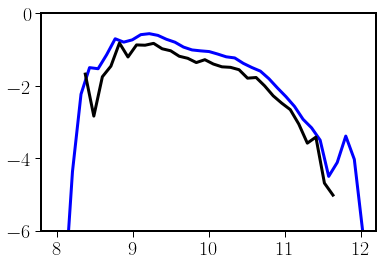

In [27]:
#
# Mass Luminosity Function
#
#logMs_nsa    Num_w        
#ifudsgn      nsa_nsaid    z_obs_nsa    name         
#plateifu     nsaid        Vmax_w            


x_min=7
x_max=12.5
x_par=tab_all['log_Mass'][tab_all['best type_n']>3]
x_w=tab_all['Vmax_w'][tab_all['best type_n']>3]#*len(tab_vol)#[tab_all['Vmax_w']>0]
#x_w=x_w.filled(0)
print(np.mean(x_w))
#print(x_w)
c_main='black'
alpha=1.0
n_bins=50
xx = np.linspace(x_min, x_max,n_bins)
kde_xx=stats.gaussian_kde(x_par,weights=x_w)
kde_xx.set_bandwidth(bw_method=kde_xx.factor/3)
max_kde_xx=np.max(kde_xx(xx))
yy=kde_xx(xx)/(2*np.sqrt(np.pi))#/n_bins

hy=np.histogram(x_par,bins=xx,weights=x_w)
hy=np.array(hy)
hy[0]=hy[0]*(n_bins-1)
hx=np.zeros(len(xx)-1)
for indx in range(0,len(hx),1):
    hx[indx]=0.5*(xx[indx]+xx[indx+1])
plt.plot(xx-0.25,log10(yy),color='blue',linewidth=3,alpha=alpha)
plt.plot(hx-0.25,np.log10(hy[0]),color=c_main,linewidth=3,alpha=alpha)
plt.ylim(-6,0)
plt.xlim(7.8,12.2)



#    ax_histx.set_ylim(0,1.1*np.max(kde_xx(xx)))   
#print(np.median(hy[0]))
#print(np.median(yy))
#a=np.median(yy)/np.median(hy[0])
#print(a)

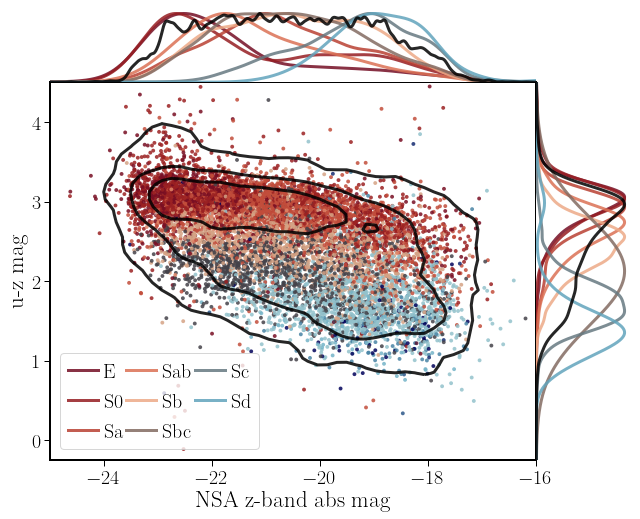

In [28]:
def plot_2Dhist(x_par=tab_all['z abs'],y_par=tab_all['u-z'],z_par=tab_all['best type_n'],\
                x_min=-25,x_max=-16,y_min=0,y_max=4.5,z_min=-2,z_max=10,c_main='grey',label='MPL-11',\
                x_label='NSA z-band abs mag',y_label='u-z mag',figname='CMD_diag',alpha=0.75,\
                   size_scatter=5.0,n_zbins=11,labels_zbins=None,color_cm_now='coolwarm_r',z_lim=80,\
               x_loc=0.02,y_loc=0.03,z_label='',reverse=0, xscale='linear', yscale='linear'):

    fig = plt.figure(figsize=(9,7))
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.00
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 1-(bottom+height)]
    rect_histy = [left + width + spacing, bottom, 1-(left+width), height]
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    if (color_cm_now is None):
        color_cm_now = vel_map()
        if (reverse==1):
            color_cm_now=color_cm_now.reversed()
    colormap=cm.get_cmap(color_cm_now)


#    colormap = plt.cm(color_cm_now)
    ax.scatter(x_par, y_par, s=size_scatter*3, c=z_par,\
               vmin=z_min,vmax=z_max,alpha=alpha,edgecolor='none',cmap=color_cm_now,\
               rasterized=True,label=label)
    my_contour(ax,x_par,y_par,x_min,x_max,y_min,y_max,c_color=c_main,\
               nbins=50,title=label,linewidths=3,alpha=alpha)
#
# X-histogram 
#
    
    
    xx = np.linspace(x_min, x_max, 1000)
    kde_xx=stats.gaussian_kde(x_par)
    kde_xx.set_bandwidth(bw_method=kde_xx.factor / 5.)
    max_kde_xx=np.max(kde_xx(xx))
    
    delta_z=(z_max-z_min)/n_zbins
    Ncolors = min(colormap.N,n_zbins)
    mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]
    if (labels_zbins==None):
        labels_zbins=np.zeros(n_zbins)
    for indx,z_bins in enumerate(np.linspace(z_min,z_max,n_zbins)):
        z_bin_min = z_bins-0.5*delta_z
        z_bin_max = z_bins+0.5*delta_z
        if (labels_zbins[indx]==0):
            labels_zbins[indx]=z_bins
        xx = np.linspace(x_min, x_max, 1000)
        mask_z_par = (z_par>z_bin_min) & (z_par<=z_bin_max)
        if (len(x_par[mask_z_par])>0):
            kde=stats.gaussian_kde(x_par[mask_z_par])
            kde.set_bandwidth(bw_method=kde.factor / 1.)
            if(len(x_par[mask_z_par])>z_lim):
                ax_histx.plot(xx,max_kde_xx*(kde(xx)/np.max(kde(xx))),\
                              color=mapcolors[indx],linewidth=3,alpha=alpha,\
                              label=labels_zbins[indx])
    ax_histx.plot(xx,kde_xx(xx),color=c_main,linewidth=3,alpha=alpha)
    ax_histx.set_ylim(0,1.1*np.max(kde_xx(xx)))    
#
# Y-histogram 
#

    yy = np.linspace(y_min, y_max, 1000)
    kde_yy=stats.gaussian_kde(y_par)
    kde_yy.set_bandwidth(bw_method=kde_yy.factor / 2.)
    max_kde_yy=np.max(kde_yy(yy))
    for indx,z_bins in enumerate(np.linspace(z_min,z_max,n_zbins)):
        z_bin_min = z_bins-0.5*delta_z
        z_bin_max = z_bins+0.5*delta_z
        if (labels_zbins[indx]==0):
            labels_zbins[indx]=z_bins
        mask_z_par = (z_par>z_bin_min) & (z_par<=z_bin_max)
        #print(z_bins,len(x_par[mask_z_par]))
        if (len(y_par[mask_z_par])>0):
            kde=stats.gaussian_kde(y_par[mask_z_par])
            kde.set_bandwidth(bw_method=kde.factor / 1.)
            if(len(y_par[mask_z_par])>z_lim):
                ax_histy.plot(max_kde_yy*(kde(yy)/np.max(kde(yy))),yy,\
                              color=mapcolors[indx],linewidth=3,alpha=alpha,\
                              label=labels_zbins[indx])
    
    
    ax_histy.plot(kde_yy(yy),yy,color=c_main,linewidth=3,alpha=alpha)
    ax_histy.set_xlim(0,1.1*np.max(kde_yy(yy)))

    ax_histx.spines['right'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['bottom'].set_visible(False)
    ax_histx.spines['left'].set_visible(False)
    ax_histx.get_xaxis().set_visible(False)
    ax_histx.get_yaxis().set_visible(False)

    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(False)
    ax_histy.spines['left'].set_visible(False)
    ax_histy.get_xaxis().set_visible(False)
    ax_histy.get_yaxis().set_visible(False)

    ax.set_xlabel(x_label, fontsize=23)
    ax.set_ylabel(y_label, fontsize=23)

    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)

    handles, labels = ax_histx.get_legend_handles_labels()
    ax.legend(handles, labels,loc=(x_loc,y_loc),frameon=True,\
              handlelength=1.5,ncol=3,columnspacing=0.15,title=z_label)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    fig.tight_layout()
    fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

morph_list=[]
for key, value in morph.items():
    temp = value
    morph_list.append(temp)
    
plot_2Dhist(x_par=tab_all['z abs'],y_par=tab_all['u-z'],z_par=tab_all['best type_n'],\
            x_min=-25,x_max=-16,y_min=-0.25,y_max=4.5,z_min=-2,z_max=10,c_main='black',label='MPL-11',\
            x_label='NSA z-band abs mag',y_label='u-z mag',figname='CMD_diag',alpha=0.85,\
            size_scatter=5.0,n_zbins=13,z_lim=80,labels_zbins=morph_list,color_cm_now=None,\
            reverse=1)#'Spectral_r')

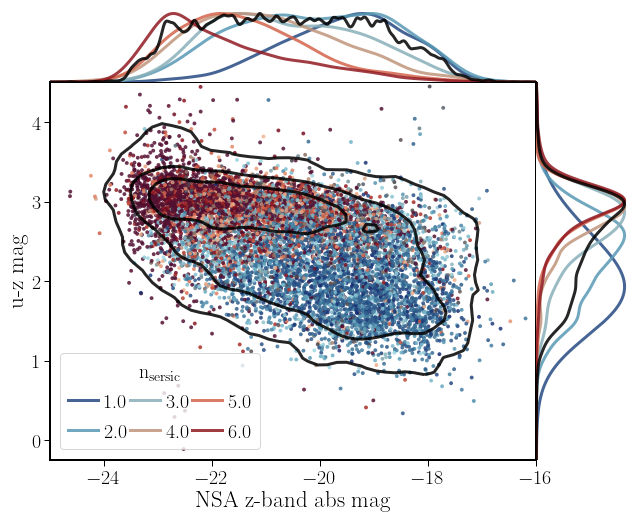

In [29]:
mask = tab_all['z_stars']>0
x_par=tab_all['z abs'][mask]
y_par=tab_all['u-z'][mask]
z_par=tab_all['nsa_sersic_n_morph'][mask]
plot_2Dhist(x_par=x_par,y_par=y_par,z_par=z_par,\
            x_min=-25,x_max=-16,y_min=-0.25,y_max=4.5,z_min=0,z_max=6,c_main='black',label='MPL-11',\
            x_label='NSA z-band abs mag',y_label='u-z mag',figname='CMD_nSersic',alpha=0.85,\
            size_scatter=5.0,n_zbins=7,z_lim=80,labels_zbins=None,color_cm_now=None,\
           z_label=r'n$_{\rm sersic}$')#'Spectral_r')

In [30]:
def read_Pipe3D(name,DIR='',verbose=0):
    dat=name.split("-")
    plate=dat[1]
    ifu=dat[2]
    DIR_plate=DIR+"/"+plate+"/"
    Pipe3D_file=DIR_plate+name+".Pipe3D.cube.fits.gz"
    Pipe3D_hdu=fits.open(Pipe3D_file)


    ######################################################
    # SSP cube                                           #
    ######################################################    
    SELECT_REG_data=Pipe3D_hdu[8].data
    SSP_data=Pipe3D_hdu[1].data
    SSP_hdr=Pipe3D_hdu[1].header
    (nz,ny,nx)=SSP_data.shape
    SSP_maps={}
    SSP_key={}
    SSP_key[0]="V"
    SSP_key[1]="CS"
    SSP_key[2]="DZ"
    SSP_key[3]="med"
    SSP_key[4]="std"
    SSP_key[5]="A_L"
    SSP_key[6]="A_M"
    SSP_key[7]="e_A_M"
    SSP_key[8]="Z_L"
    SSP_key[9]="Z_M"
    SSP_key[10]="e_Z_M"
    SSP_key[11]="Av"
    SSP_key[12]="e_Av"
    SSP_key[13]="vel"
    SSP_key[14]="e_vel"
    SSP_key[15]="sig"
    SSP_key[16]="e_sig"
    SSP_key[17]="ML"
    SSP_key[18]="M"
    SSP_key[19]="Md"
    SSP_key[20]="e_M"
    for indx in arange(0,nz):
        val=SSP_key[indx]
#        print(indx,val)
        image=SSP_data[indx,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        if ((indx!=13) and (indx!=14) and (indx!=8) and (indx!=9)):
            image=np.ma.masked_array(image,\
                                 ~(image>0.0))
        else:
            image=np.ma.masked_array(image,\
                                 (image==0.0))
        SSP_maps[val]=image

        
    ######################################################
    # SFH cube                                           #
    ######################################################
    SFH_data=Pipe3D_hdu[2].data
    SFH_hdr=Pipe3D_hdu[2].header
    (nz,ny,nx)=SFH_data.shape
    SFH_maps={}
    SFH_key={}
    age_met=[]
    age=[]
    met=[]
    n_age=0
    n_met=0
    n_age_met=0
    for i in arange(0,nz):
        key='DESC_'+str(i)
        mark_labels=SFH_hdr[key]    
        mark_labels=mark_labels.replace('Luminosity Fraction for ','')
        mark_labels=mark_labels.replace(' SSP','')
        SFH_key[i]=mark_labels.replace(' ','_')
        image=SFH_data[i,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))               
        SFH_maps[SFH_key[i]]=image
        if (mark_labels.find('age-met')>-1):
            n_age_met=n_age_met+1
            age_met.append(mark_labels.replace('age-met ',''))
        else:
            if (mark_labels.find('age')>-1):
                n_age=n_age+1
                age.append(mark_labels.replace('age ',''))
            else:
                if (mark_labels.find('met')>-1):
                    n_met=n_met+1
                    met.append(mark_labels.replace('met ',''))
       
    age_met=np.array(age_met)
    age=np.array(age)
    met=np.array(met)    
   
    ######################################################
    # IND cube                                           #
    ######################################################
    IND_data=Pipe3D_hdu[3].data
    IND_hdr=Pipe3D_hdu[3].header
    (nz,ny,nx)=IND_data.shape
    IND_maps={}
    IND_key={}
    for i in arange(0,nz):
        key='INDEX'+str(i)
        mark_labels=IND_hdr[key]    
        IND_key[i]=mark_labels.replace(' ','_')
        image=IND_data[i,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))               
        IND_maps[IND_key[i]]=image

    ######################################################
    # ELINES cube                                        #
    ######################################################
    ELINES_data=Pipe3D_hdu[4].data
    ELINES_hdr=Pipe3D_hdu[4].header
    (nz,ny,nx)=ELINES_data.shape
    ELINES_maps={}
    ELINES_key={}
    for i in arange(0,nz):
        key='DESC_'+str(i)
        mark_labels=ELINES_hdr[key]    
        mark_labels=mark_labels.replace(' emission line','')
        mark_labels=mark_labels.replace('Halpha velocity','vel_Ha')    
        mark_labels=mark_labels.replace('Velocity dispersion plus instrumenta one','disp_Ha')
        mark_labels=mark_labels.replace('Halpha','Ha')
        mark_labels=mark_labels.replace('Hbeta','Hb')
        ELINES_key[i]=mark_labels.replace(' ','')
        image=ELINES_data[i,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))               
        ELINES_maps[ELINES_key[i]]=image

    ######################################################
    # FLUX_ELINES cube                                           #
    ######################################################
    FE_data=Pipe3D_hdu[5].data
    FE_hdr=Pipe3D_hdu[5].header
    (nz,ny,nx)=FE_data.shape
    FE_maps={}
    FE_key={}
    for i in arange(0,nz):
        key='NAME'+str(i)
        wave='WAVE'+str(i)
        mark_labels=FE_hdr[key]+'_'+FE_hdr[wave]    
        FE_key[i]=mark_labels.replace(' ','_')
        image=FE_data[i,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))               
        FE_maps[FE_key[i]]=image
        
    ######################################################
    # FLUX_ELINES_LONG cube                                           #
    ######################################################
    FEL_data=Pipe3D_hdu[6].data
    FEL_hdr=Pipe3D_hdu[6].header
    (nz,ny,nx)=FEL_data.shape
    FEL_maps={}
    FEL_key={}
    for i in arange(0,nz):
        key='NAME'+str(i)
        wave='WAVE'+str(i)
        mark_labels=FEL_hdr[key]+'_'+FEL_hdr[wave]    
        FEL_key[i]=mark_labels.replace(' ','_')
        image=FEL_data[i,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))               
        FEL_maps[FEL_key[i]]=image
        
    ######################################################
    # GAIA cube                                           #
    ######################################################
    GA_data=Pipe3D_hdu[7].data
    GA_hdr=Pipe3D_hdu[7].header        
    
    ######################################################
    # SEG map                                           #
    ######################################################
    MASK_data=Pipe3D_hdu[8].data
    MASK_hdr=Pipe3D_hdu[8].header        
        
    if (verbose==1):
        print(Pipe3D_hdu.info())
        print('SSP:',SSP_key)
        print('n_SSPs:',n_age_met,', n_ages:',n_age,n_met)
        print('SFH:',SFH_key)
        print('IND:',IND_key)
        print('ELINES:',ELINES_key)
        print('FE:',FE_key)
        print('FEL:',FEL_key)
  
    output={'hdr':Pipe3D_hdu[0].header,'SSP':SSP_maps,'SFH':SFH_maps,\
            'AGE':age,'MET':met,'AGE-MET':age_met,\
           'IND':IND_maps,'ELINES':ELINES_maps,\
           'FE':FE_maps,'FEL':FEL_maps,'GAIA_MASK':GA_data,'MASK':MASK_data}
    return output
#    return ()
    
#maps=read_Pipe3D_MaNGA('manga-7495-12704',DIR='/disk-e/manga/data/v3_1_1/Pipe3D/',verbose=0)
    

In [31]:
for age_met in maps['MET']:
    print(age_met,SSP_ML_met[age_met])
print(np.sum(np.array(list(SSP_ML_met.values()))))


0.0001 1.6730031324076715
0.0005 1.7156131925443463
0.0020 1.9652256383847453
0.0080 2.68937157174964
0.0170 3.373432982673602
0.0300 4.143709608634502
0.0400 4.586811471313965
20.147167597708474


In [32]:
#maps2=read_Pipe3D('manga-7443-12702',DIR='/disk-e/manga/data/v3_1_1/Pipe3D/',verbose=1)
#plt.imshow(maps2['MASK'])

In [33]:
#plt.imshow(maps2['FEL']['flux_Halpha_6562.85'])

In [34]:
#al=np.array(list(maps['FE'].keys()))
#print(al[np.char.find(al,'Ha')>-1])
#al=np.array(list(maps['FEL'].keys()))
#print(al[np.char.find(al,'Ha')>-1])

#plt.scatter(maps['FE']['flux_Ha_6562.68'],maps['ELINES']['Ha'])
#plt.scatter(maps2['FE']['flux_Ha_6562.68'],maps2['FEL']['flux_Halpha_6562.85'])


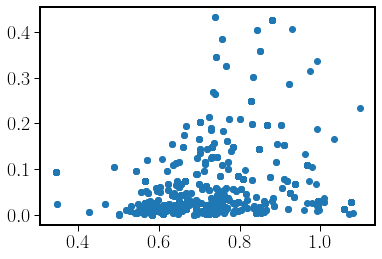

In [35]:
plt.scatter(maps['SSP']['ML'],maps['SFH']['age_6.2500'])

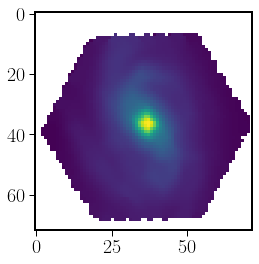

In [36]:
#print(maps['SSP']['V'])
plt.imshow(maps['SSP']['V'])

In [37]:
#
# Map plots!
#
#DIR='/disk-e/manga/data/v3_1_1/Pipe3D/'
DIR='data'
name_now="manga-7495-12704"
dat=name_now.split("-")
plate=dat[1]
ifu=dat[2]
DIR_plate=DIR+"/"+plate+"/"
Pipe3D_file=DIR_plate+name_now+".Pipe3D.cube.fits.gz"
Pipe3D_hdu=fits.open(Pipe3D_file)
print(Pipe3D_hdu.info())

SELECT_REG_data=Pipe3D_hdu[8].data
SSP_data=Pipe3D_hdu[1].data
SSP_hdr=Pipe3D_hdu[1].header
(nz,ny,nx)=SSP_data.shape
SSP_maps={}
SSP_key={}
SSP_key[0]="V"
SSP_key[1]="CS"
SSP_key[2]="DZ"
SSP_key[3]="med"
SSP_key[4]="std"
SSP_key[5]="A_L"
SSP_key[6]="A_M"
SSP_key[7]="e_A_M"
SSP_key[8]="Z_L"
SSP_key[9]="Z_M"
SSP_key[10]="e_Z_M"
SSP_key[11]="Av"
SSP_key[12]="e_Av"
SSP_key[13]="vel"
SSP_key[14]="e_vel"
SSP_key[15]="sig"
SSP_key[16]="e_sig"
SSP_key[17]="ML"
SSP_key[18]="M"
SSP_key[19]="Md"
SSP_key[20]="e_M"

for indx in arange(0,nz):
    val=SSP_key[indx]
    print(indx,val)
    image=SSP_data[indx,:,:]
    image = np.ma.masked_invalid(image)
    image=image*SELECT_REG_data
    image=image*1.0
    if ((indx!=13) and (indx!=14) and (indx!=8) and (indx!=9)):
        image=np.ma.masked_array(image,\
                                 ~(image>0.0))
    else:
        image=np.ma.masked_array(image,\
                                 (image==0.0))
    SSP_maps[val]=image
    
#print(SSP_maps['V'])
#plt.imshow(SSP_maps['V'])

Filename: data/7495/manga-7495-12704.Pipe3D.cube.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  ORG_HDR       1 PrimaryHDU      97   ()      
  1  SSP           1 ImageHDU       118   (72, 72, 21)   float64   
  2  SFH           1 ImageHDU      1608   (72, 72, 319)   float64   
  3  INDICES       1 ImageHDU        31   (72, 72, 18)   float64   
  4  ELINES        1 ImageHDU        68   (72, 72, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1382   (72, 72, 456)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      4622   (72, 72, 1536)   float64   
  7  GAIA_MASK     1 ImageHDU        28   (72, 72)   float64   
  8  SELECT_REG    1 ImageHDU        10   (72, 72)   float64   
None
0 V
1 CS
2 DZ
3 med
4 std
5 A_L
6 A_M
7 e_A_M
8 Z_L
9 Z_M
10 e_Z_M
11 Av
12 e_Av
13 vel
14 e_vel
15 sig
16 e_sig
17 ML
18 M
19 Md
20 e_M


DESC_0 pseudo V-band map
DESC_1  continuum segmentation file
DESC_2  continuum dezonification file
DESC_3  median intensity flux within the wavelength range
DESC_4  StdDev median intensity flux within the wavelength range
DESC_5  luminosity weighted age of the stellar population
DESC_6  mass weighted age of the stellar population
DESC_7  error of the age of the stellar population
DESC_8  luminosity weighted metallicity of the stellar population
DESC_9  mass weighted metallicity of the stellar population
DESC_10  error metallicity of the stellar population
DESC_11  average dust attnuation of the stellar population
DESC_12  error of the average dust attnuation of the stellar population
DESC_13  velocity of the stellar population
DESC_14  error in the velocity of the stellar population
DESC_15  velocity dispersion of the stellar population
DESC_16  error in velocity dispersion of the stellar population
DESC_17  average mass-to-light ratio of the stellar population
DESC_18  stellar mass de

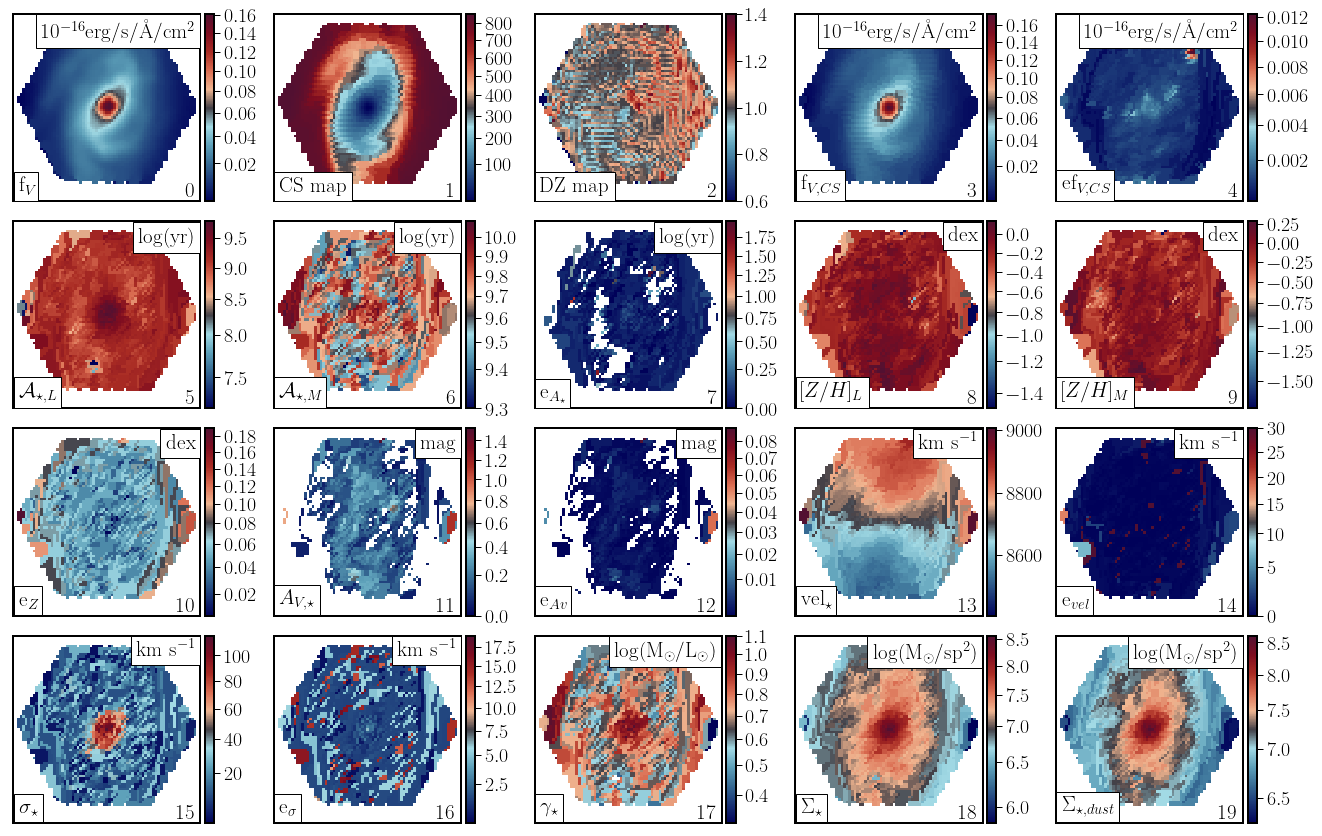

In [38]:
figname=name_now+".SSP"
SELECT_REG_data=Pipe3D_hdu[8].data
SSP_data=Pipe3D_hdu[1].data
SSP_hdr=Pipe3D_hdu[1].header
(nz,ny,nx)=SSP_data.shape
SSP_maps={}
#labels=['V-band img','CS map','DZ map','']
#for i in arange(0,nz,1):
#    key='DESC_'+str(i)
#    val=SSP_hdr[key]
#print(SELECT_REG_data)

SSP_labels={}#np.zeros(nz)
SSP_labels[0]=r'f$_V$'
SSP_labels[1]='CS map'
SSP_labels[2]='DZ map'
SSP_labels[3]=r'f$_{V,CS}$'#DESC_3  median intensity flux within the wavelength range
SSP_labels[4]=r'ef$_{V,CS}$'#  StdDev median intensity flux within the wavelength range
SSP_labels[5]=r'$\mathcal{A}_{\star,L}$'#  luminosity weighted age of the stellar population
SSP_labels[6]=r'$\mathcal{A}_{\star,M}$'#  mass weighted age of the stellar population
SSP_labels[7]=r'e$_{A_\star}$'  #error of the age of the stellar population
SSP_labels[8]=r'$[Z/H]_L$'#  luminosity weighted metallicity of the stellar population
SSP_labels[9]=r'$[Z/H]_M$'#  mass weighted metallicity of the stellar population
SSP_labels[10]=r'e$_{Z}$'#  error metallicity of the stellar population
SSP_labels[11]=r'$A_{V,\star}$'#  average dust attnuation of the stellar population
SSP_labels[12]=r'e$_{Av}$'#  error of the average dust attnuation of the stellar population
SSP_labels[13]=r'vel$_\star$'#  velocity of the stellar population
SSP_labels[14]=r'e$_{vel}$'#  error in the velocity of the stellar population
SSP_labels[15]=r'$\sigma_\star$'#  velocity dispersion of the stellar population
SSP_labels[16]=r'e$_\sigma$'#  error in velocity dispersion of the stellar population
SSP_labels[17]=r'$\gamma_\star$'#  average mass-to-light ratio of the stellar population
SSP_labels[18]=r'$\Sigma_\star$'#  stellar mass density
SSP_labels[19]=r'$\Sigma_{\star,dust}$' #   stellar mass density dust corrected

SSP_ulabels={}#np.zeros(nz)
SSP_ulabels[0]='10$^{-16}$erg/s/\AA/cm$^2$'#erg s$^{-1}$ cm$^{-2}$'
SSP_ulabels[1]=''
SSP_ulabels[2]=''
SSP_ulabels[3]=r'10$^{-16}$erg/s/\AA/cm$^2$'#erg s$^{-1}$ cm$^{-2}$'#DESC_3  median intensity flux within the wavelength range
SSP_ulabels[4]=r'10$^{-16}$erg/s/\AA/cm$^2$'#erg s$^{-1}$ cm$^{-2}$'#  StdDev median intensity flux within the wavelength range
SSP_ulabels[5]=r'log(yr)'#  luminosity weighted age of the stellar population
SSP_ulabels[6]=r'log(yr)'#  mass weighted age of the stellar population
SSP_ulabels[7]=r'log(yr)'  #error of the age of the stellar population
SSP_ulabels[8]=r'dex'#  luminosity weighted metallicity of the stellar population
SSP_ulabels[9]=r'dex'#  mass weighted metallicity of the stellar population
SSP_ulabels[10]=r'dex'#  error metallicity of the stellar population
SSP_ulabels[11]=r'mag'#  average dust attnuation of the stellar population
SSP_ulabels[12]=r'mag'#  error of the average dust attnuation of the stellar population
SSP_ulabels[13]=r'km s$^{-1}$'#  velocity of the stellar population
SSP_ulabels[14]=r'km s$^{-1}$'#  error in the velocity of the stellar population
SSP_ulabels[15]=r'km s$^{-1}$'#  velocity dispersion of the stellar population
SSP_ulabels[16]=r'km s$^{-1}$'#  error in velocity dispersion of the stellar population
SSP_ulabels[17]=r'log(M$_\odot$/L$_\odot$)'#  average mass-to-light ratio of the stellar population
SSP_ulabels[18]=r'log(M$_\odot$/sp$^2$)'#  stellar mass density
SSP_ulabels[19]=r'log(M$_\odot$/sp$^2$)' #   stellar mass density dust corrected



fig, axes = plt.subplots(4,5, figsize=(19,12))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

for indx,ax in enumerate(axes.flat):
    key='DESC_'+str(indx)
    val=SSP_hdr[key]
    print(key,val)
    image=SSP_data[indx,:,:]
    image = np.ma.masked_invalid(image)
    image=image*SELECT_REG_data
    image=image*1.0
    if ((indx!=13) and (indx!=14) and (indx!=8) and (indx!=9)):
        image=np.ma.masked_array(image,\
                                 ~(image>0.0))
    else:
        image=np.ma.masked_array(image,\
                                 (image==0.0))
    if ((indx!=0) and (indx!=3) and (indx!=4) and (indx!=12)):
        image=np.around(image,2)
    vmin=np.min(image)
    vmax=np.max(image)
    norm=colors.PowerNorm(gamma=0.75)
    if (indx==13):
        vmin=np.ma.median(image)-300
        vmax=np.ma.median(image)+300
        norm=None
    if (indx==2):
        vmin=1.4
        vmax=0.6
        norm=None
#        print(indx,val,vmin,vmax)
    im_now=ax.imshow(image, interpolation='none',\
                     cmap=cmap, \
                     norm=norm,\
                      vmin=vmin,vmax=vmax)
    fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
    ax.set_xlim(0,nx)
    ax.set_ylim(0,ny)
    ax.text(0.03*nx, 0.03*ny, SSP_labels[indx], fontsize=21, bbox={'facecolor': 'white', 'pad': 5},\
           va='bottom',ha='left')
    ax.text(0.97*nx, 0.97*ny, SSP_ulabels[indx], fontsize=21, bbox={'facecolor': 'white', 'pad': 5},\
            va='top',ha='right')
    ax.text(0.97*nx, 0.1*ny, str(indx), fontsize=21,\
            va='top',ha='right')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.35,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [39]:
figname=name_now+".SFH"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    print(i,mark_labels_now)
#    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
#    mark_labels_now=mark_labels_now.replace(' SSP','')
#    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])


0 Luminosity Fraction for age-met 0.0010-0.0001 SSP
1 Luminosity Fraction for age-met 0.0010-0.0005 SSP
2 Luminosity Fraction for age-met 0.0010-0.0020 SSP
3 Luminosity Fraction for age-met 0.0010-0.0080 SSP
4 Luminosity Fraction for age-met 0.0010-0.0170 SSP
5 Luminosity Fraction for age-met 0.0010-0.0300 SSP
6 Luminosity Fraction for age-met 0.0010-0.0400 SSP
7 Luminosity Fraction for age-met 0.0023-0.0001 SSP
8 Luminosity Fraction for age-met 0.0023-0.0005 SSP
9 Luminosity Fraction for age-met 0.0023-0.0020 SSP
10 Luminosity Fraction for age-met 0.0023-0.0080 SSP
11 Luminosity Fraction for age-met 0.0023-0.0170 SSP
12 Luminosity Fraction for age-met 0.0023-0.0300 SSP
13 Luminosity Fraction for age-met 0.0023-0.0400 SSP
14 Luminosity Fraction for age-met 0.0038-0.0001 SSP
15 Luminosity Fraction for age-met 0.0038-0.0005 SSP
16 Luminosity Fraction for age-met 0.0038-0.0020 SSP
17 Luminosity Fraction for age-met 0.0038-0.0080 SSP
18 Luminosity Fraction for age-met 0.0038-0.0170 SSP
19 

153 Luminosity Fraction for age-met 0.5500-0.0400 SSP
154 Luminosity Fraction for age-met 0.6500-0.0001 SSP
155 Luminosity Fraction for age-met 0.6500-0.0005 SSP
156 Luminosity Fraction for age-met 0.6500-0.0020 SSP
157 Luminosity Fraction for age-met 0.6500-0.0080 SSP
158 Luminosity Fraction for age-met 0.6500-0.0170 SSP
159 Luminosity Fraction for age-met 0.6500-0.0300 SSP
160 Luminosity Fraction for age-met 0.6500-0.0400 SSP
161 Luminosity Fraction for age-met 0.8500-0.0001 SSP
162 Luminosity Fraction for age-met 0.8500-0.0005 SSP
163 Luminosity Fraction for age-met 0.8500-0.0020 SSP
164 Luminosity Fraction for age-met 0.8500-0.0080 SSP
165 Luminosity Fraction for age-met 0.8500-0.0170 SSP
166 Luminosity Fraction for age-met 0.8500-0.0300 SSP
167 Luminosity Fraction for age-met 0.8500-0.0400 SSP
168 Luminosity Fraction for age-met 1.1000-0.0001 SSP
169 Luminosity Fraction for age-met 1.1000-0.0005 SSP
170 Luminosity Fraction for age-met 1.1000-0.0020 SSP
171 Luminosity Fraction for 

312 Luminosity Fraction for met 0.0001 SSP
313 Luminosity Fraction for met 0.0005 SSP
314 Luminosity Fraction for met 0.0020 SSP
315 Luminosity Fraction for met 0.0080 SSP
316 Luminosity Fraction for met 0.0170 SSP
317 Luminosity Fraction for met 0.0300 SSP
318 Luminosity Fraction for met 0.0400 SSP


72 72 39
10


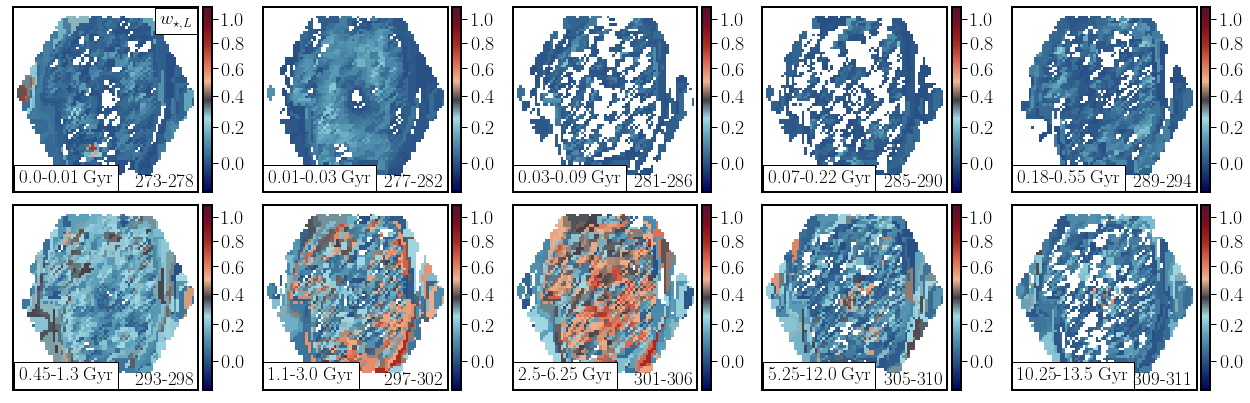

In [40]:
figname=name_now+".SFH"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
n_bin=4
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))
label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=n_bin*(i+1)+1
    if (j_max>=I_max):
        j_max=I_max-1
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+SFH_age[j,:,:]
#        print(i,mark_labels_bin[i])
#        print(i,j)

print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.min(image)
        vmax=np.max(image)
        norm=colors.PowerNorm(gamma=0.75)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm,\
                         vmin=-0.1,vmax=1.1)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, \
                bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'$w_{\star,L}$', fontsize=19,\
                    bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')        
    else:
        ax.set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

72 72 7


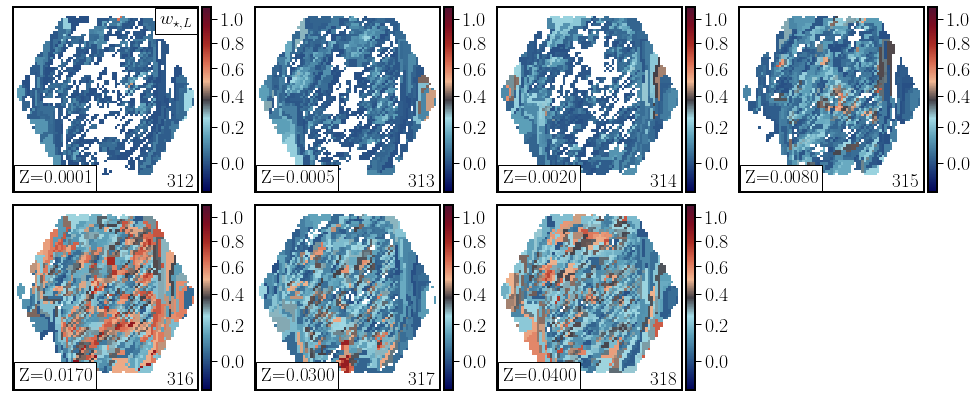

In [41]:
figname=name_now+".SFH_Z"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
#label_index={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for met ','')
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age-met ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    label_index[I]
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7+39
I_max=7
n_end=n_start+I_max
SFH_met=SFH_data[n_start:n_end,:,:]
(nz_met,ny_met,nx_met)=SFH_met.shape
print(nx_met,ny_met,nz_met)

NY=2
NX=4
fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(3*NY)))
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

for I,ax in enumerate(axes.flat):
    if (I<I_max):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_met[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.min(image)
        vmax=np.max(image)
        norm=colors.PowerNorm(gamma=0.75)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm,\
                         vmin=-0.1,vmax=1.1)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, 'Z='+mark_labels[I+n_start], fontsize=19, \
                bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'$w_{\star,L}$', fontsize=19,\
                    bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, str(I+n_start), fontsize=19,\
                va='top',ha='right')        
    else:
        ax.set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [42]:
figname=name_now+".SFH_L"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
n_bin=4
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))
label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=n_bin*(i+1)+1
    if (j_max>=I_max):
        j_max=I_max-1
#    label_index[i]=str(j_min)+'-'+str(j_max-1)
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+SFH_age[j,:,:]*SSP_data[0,:,:]*SSP_data[2,:,:]
#        print(i,mark_labels_bin[i])
#        print(i,j)

print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        #image=np.around(image,2)
        vmin=np.min(SSP_data[0,:,:]*0.5)
        vmax=np.max(SSP_data[0,:,:]*0.5)
        norm=colors.PowerNorm(gamma=0.75)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm,\
                         vmin=vmin,vmax=vmax)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'f$_V$[10$^{-16}$erg/s/cm^2]', fontsize=19, \
                    bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')
    else:
        ax.set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

72 72 39
10


RuntimeError: latex was not able to process the following string:
b'f$_V$[10$^{-16}$erg/s/cm^2]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/sanchez/.cache/matplotlib/tex.cache/0022ae5cfdc0639fd31abb09763bbd9b.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./0022ae5cfdc0639fd31abb09763bbd9b.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily f$_V$[10$^{-16}$erg/s/cm^
                                         2]}
No pages of output.
Transcript written on 0022ae5cfdc0639fd31abb09763bbd9b.log.




RuntimeError: latex was not able to process the following string:
b'f$_V$[10$^{-16}$erg/s/cm^2]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/sanchez/.cache/matplotlib/tex.cache/0022ae5cfdc0639fd31abb09763bbd9b.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./0022ae5cfdc0639fd31abb09763bbd9b.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily f$_V$[10$^{-16}$erg/s/cm^
                                         2]}
No pages of output.
Transcript written on 0022ae5cfdc0639fd31abb09763bbd9b.log.




<Figure size 1296x432 with 20 Axes>

In [ ]:
figname=name_now+".SFH_M"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
n_bin=4
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))
label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=n_bin*(i+1)+1
    if (j_max>=I_max):
        j_max=I_max-1
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+SFH_age[j,:,:]*10**(SSP_data[18,:,:])*SSP_data[2,:,:]
    SFH_age_bin[i,:,:]=np.log10(SFH_age_bin[i,:,:])
#        print(i,mark_labels_bin[i])
#        print(i,j)

print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.nanmin(image)
        vmax=np.nanmax(image)
#        vmin=np.nanmin(SSP_data[18,:,:])
#        vmax=np.nanmax(SSP_data[18,:,:])
        print(I,vmin,vmax)
        norm=colors.PowerNorm(gamma=0.75)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm,\
                         vmin=vmin,vmax=vmax)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'log($\Sigma_\star$)[M$_\odot$/sp$^2$]', fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')
        
    else:
        ax.set_visible(False)
                
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [ ]:
figname=name_now+".SFH_CM"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
n_bin=4
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))
label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=I_max-1#n_bin*(i+1)+1
    #if (j_max>=I_max):
    #    j_max=I_max-1
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+SFH_age[j,:,:]*10**(SSP_data[18,:,:])*SSP_data[2,:,:]
        
    SFH_age_bin[i,:,:]=np.log10(SFH_age_bin[i,:,:])
#    print(i,mark_labels_bin[i])
#        print(i,j)

#print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.nanmin(SSP_data[18,:,:][SSP_data[18,:,:]>0])
        vmax=np.nanmax(SSP_data[18,:,:][SSP_data[18,:,:]>0])
#        vmin=np.nanmin(image[image>0])
#        vmax=np.nanmax(image[image>0])
        print(I,vmin,vmax)
        norm=colors.PowerNorm(gamma=0.75)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm,\
                         vmin=vmin*0.9,vmax=vmax*1.1)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'log($\Sigma_\star$)[M$_\odot$/sp$^2$]', fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')
    else:
        ax.set_visible(False)
        
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

  0  ORG_HDR       1 PrimaryHDU      97   ()      
  1  SSP           1 ImageHDU       118   (72, 72, 21)   float64   
  2  SFH           1 ImageHDU      1608   (72, 72, 319)   float64   
  3  INDICES       1 ImageHDU        31   (72, 72, 18)   float64   
  4  ELINES        1 ImageHDU        68   (72, 72, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1382   (72, 72, 456)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      4622   (72, 72, 1536)   float64   
  7  GAIA_MASK     1 ImageHDU        28   (72, 72)   float64   
  8  SELECT_REG    1 ImageHDU        10   (72, 72)   float64   


In [ ]:
figname=name_now+".IND"
SELECT_REG_data=Pipe3D_hdu[8].data
IND_data=Pipe3D_hdu[3].data
IND_hdr=Pipe3D_hdu[3].header
(nz,ny,nx)=IND_data.shape
IND_maps={}
print(nx,ny,nz)

#print(IND_hdr.keys())
#IND_labels={}#np.zeros(nz)
#IND_ulabels={}#np.zeros(nz)
#for indx,keys in enumerate(list(IND_hdr.keys())):
#    print (keys,IND_hdr[keys])
#    IND_labels[indx]=r'$'+str(IND_hdr[keys])+'$'
#    IND_ulabels[indx]=r'$\AA$'


NY=3
NX=6
fig, axes = plt.subplots(NY,NX, figsize=(int(3.675*NX),int(3*NY)))

color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

for indx,ax in enumerate(axes.flat):
    image=IND_data[indx,:,:]
    image = np.ma.masked_invalid(image)
    image=image*SELECT_REG_data
    image=image*1.0
    mask_img = (image==0)
    image=ma.masked_array(image,mask=mask_img)
    a=image
    x,y=np.mgrid[0:a.shape[0],0:a.shape[1]]
    xygood = np.array((x[~a.mask],y[~a.mask])).T
    xybad = np.array((x[a.mask],y[a.mask])).T
    a[a.mask] = a[~a.mask][KDTree(xygood).query(xybad)[1]]
    image=a
    image=image*SELECT_REG_data
    image=image*1.0
    mask_img = (image==0)
    image=ma.masked_array(image,mask=mask_img)
    keys='INDEX'+str(indx)
    label_now=str(IND_hdr[keys])
    label_now=label_now.replace('_','')
    units_now=r'\AA'
    if (label_now.find('SN')>-1):
            label_now=label_now.replace('SN','flux')
            units_now=None #r'10$^{-16}$ erg/s/\AA/cm$^2$'# cgs'#erg s$^{-1}$ \AA$^{-1}$ cm$^{-2}$'
    else:
            image=np.around(image,2)
            

#    print(image)
    vmin=np.nanmin(image)
    vmin=0
    vmax=np.nanmax(image)
    norm=colors.PowerNorm(gamma=0.75)
    im_now=ax.imshow(image, interpolation='none',\
                     cmap=cmap, \
                     norm=norm,\
                      vmin=vmin,vmax=vmax)
    fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
    ax.set_xlim(0,nx)
    ax.set_ylim(0,ny)
    ax.text(0.05*nx, 0.05*ny, label_now, fontsize=21, bbox={'facecolor': 'white', 'pad': 10},\
           va='bottom',ha='left')
    if (label_now.find('D4000')==-1):
        if (units_now!=None):
            ax.text(0.94*nx, 0.95*ny, units_now, fontsize=21, bbox={'facecolor': 'white', 'pad': 10},\
                va='top',ha='right')
    ax.text(0.94*nx, 0.1*ny, str(indx), fontsize=21,\
            va='top',ha='right')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.35,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [ ]:
figname=name_now+".ELINES"
SELECT_REG_data=Pipe3D_hdu[8].data
ELINES_data=Pipe3D_hdu[4].data
ELINES_hdr=Pipe3D_hdu[4].header
(nz,ny,nx)=ELINES_data.shape
ELINES_maps={}
print(nx,ny,nz)

nz_bin=nz/8
print(nz,nz_bin)
#print(ELINES_hdr.keys())
#ELINES_labels={}#np.zeros(nz)
#ELINES_ulabels={}#np.zeros(nz)
#for indx,keys in enumerate(list(ELINES_hdr.keys())):
#    print (keys,ELINES_hdr[keys])
#    ELINES_labels[indx]=r'$'+str(ELINES_hdr[keys])+'$'
#    ELINES_ulabels[indx]=r'$\AA$'


NY=3
NX=4
#fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(3*NY)))
fig, axes = plt.subplots(NY,NX, figsize=(int(3.65*NX),int(3*NY)))

color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

for indx,ax in enumerate(axes.flat):
    if (indx<nz):
        image=ELINES_data[indx,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        mask_img = (image==0)
        image=ma.masked_array(image,mask=mask_img)
        image_Ha=ELINES_data[6,:,:]
        image_Ha = np.ma.masked_invalid(image_Ha)
        image_Ha=image_Ha*SELECT_REG_data
        image_Ha=image_Ha*1.0
        mask_img = (image_Ha==0)
        image_Ha=ma.masked_array(image_Ha,mask=mask_img)
        keys='DESC_'+str(indx)
        keys_u='UNITS_'+str(indx)
        label_now=str(ELINES_hdr[keys])
        label_now=label_now.replace(' emission line','')
        label_now=label_now.replace('Velocity dispersion plus instrumenta one',"$\sigma_{vel,H\\alpha}$")
        label_now=label_now.replace('Halpha velocity',"$v_{H\\alpha}$")
        units_now=str(ELINES_hdr[keys_u])
        vmin=np.nanmin(image)
        if (indx>1):
            vmin=0
            units_now=''#10$^{-16}$ erg/s/\AA/cm$^2$'
#            label_now=r'F'.label_now
        if (indx==1):
            units_now=r'\AA'
        if (label_now.find('Halpha')>-1):
            label_now=r'H$\alpha$'
        if (label_now.find('Hbeta')>-1):
            label_now=r'H$\beta$'
       
        vmax=np.nanmax(image)
        norm=colors.PowerNorm(gamma=0.75)
        if (indx==0):
            vmin=np.ma.median(image)-300
            vmax=np.ma.median(image)+300
            norm=None
        if (indx>1):
            vmin=-0.05
            vmax=np.nanmax(image_Ha)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                     norm=norm,\
                      vmin=vmin,vmax=vmax)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, r''+label_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        #if (len(units_now)>0):
        #    ax.text(0.96*nx, 0.97*ny, units_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
        #            va='top',ha='right')
        ax.text(0.96*nx, 0.1*ny, str(indx), fontsize=20,\
            va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    else:
        ax.set_visible(False)
fig.tight_layout(w_pad=1.0,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

72 72 456


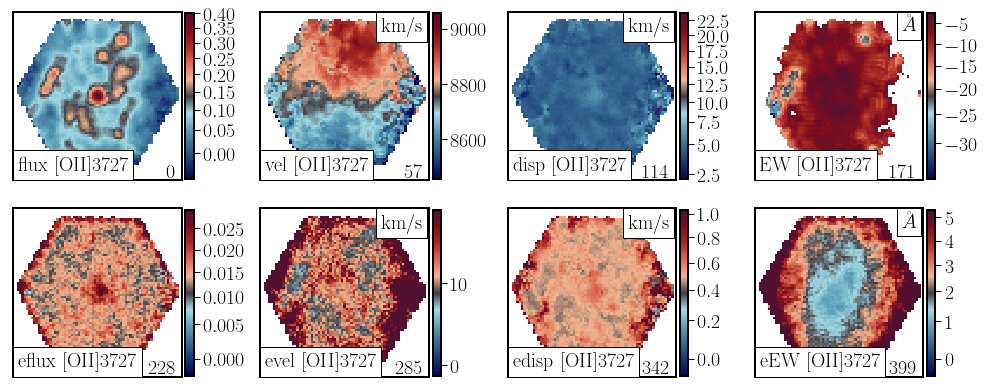

In [47]:
figname=name_now+".FLUX_ELINES"
SELECT_REG_data=Pipe3D_hdu[8].data
ELINES_data=Pipe3D_hdu[5].data
ELINES_hdr=Pipe3D_hdu[5].header
(nz,ny,nx)=ELINES_data.shape
ELINES_maps={}
print(nx,ny,nz)


NY=2
NX=4
fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(3*NY)))

color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

start_indx=0
delta_indx=57

for indx,ax in enumerate(axes.flat):
    if (indx<nz):
        indx_now=indx*delta_indx+start_indx
        image=ELINES_data[indx_now,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        mask_img = (image==0)
        image=ma.masked_array(image,mask=mask_img)
        keys='NAME'+str(indx_now)
        keys_u='UNIT'+str(indx_now)
        label_now=str(ELINES_hdr[keys])
        units_now=str(ELINES_hdr[keys_u])
        vmin=np.nanmin(image)
        vmax=np.nanmax(image)
        norm=colors.PowerNorm(gamma=0.75)
        label_now=label_now.replace('e_','e')
        if (label_now.find('flux')>-1):            
            units_now=r'10$^{-16}$ erg/s/\AA/cm$^2$'
        if (label_now.find('EW')>-1):            
            units_now=r'$\AA$'
        if (label_now.find('vel')>-1):
            vmin=np.ma.median(image)-300
            vmax=np.ma.median(image)+300
            norm=None
        if (label_now.find('evel')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=1.5*np.ma.median(image)
        if (label_now.find('edisp')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('eflux')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('eEW')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)

            
#        print(indx,vmin,vmax)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                     norm=norm,\
                      vmin=vmin,vmax=vmax)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, r''+label_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (label_now.find('flux')<0): 
            ax.text(0.96*nx, 0.97*ny, units_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.text(0.96*nx, 0.1*ny, str(indx_now), fontsize=20,\
            va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    else:
        ax.set_visible(False)
fig.tight_layout(w_pad=1.0,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

72 72 1536


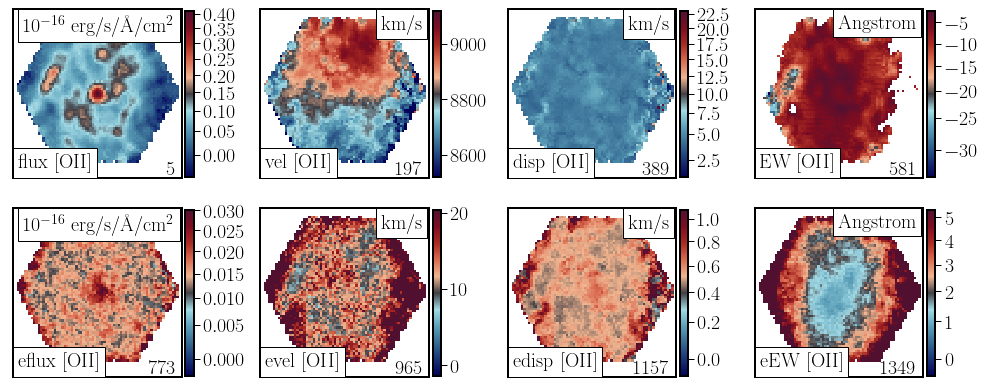

In [43]:
figname=name_now+".FLUX_ELINES_LONG"
SELECT_REG_data=Pipe3D_hdu[8].data
ELINES_data=Pipe3D_hdu[6].data
ELINES_hdr=Pipe3D_hdu[6].header
(nz,ny,nx)=ELINES_data.shape
ELINES_maps={}
print(nx,ny,nz)


NY=2
NX=4
fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(3*NY)))

color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

start_indx=5
delta_indx=192

for indx,ax in enumerate(axes.flat):
    if (indx<nz):
        indx_now=indx*delta_indx+start_indx
        image=ELINES_data[indx_now,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        mask_img = (image==0)
        image=ma.masked_array(image,mask=mask_img)
        keys='NAME'+str(indx_now)
        keys_u='UNIT'+str(indx_now)
        label_now=str(ELINES_hdr[keys])
        units_now=str(ELINES_hdr[keys_u])
        vmin=np.nanmin(image)
        vmax=np.nanmax(image)
        norm=colors.PowerNorm(gamma=0.75)
        label_now=label_now.replace('e_','e')
        if (label_now.find('flux')>-1):            
            units_now=r'10$^{-16}$ erg/s/\AA/cm$^2$'
        if (label_now.find('vel')>-1):
            vmin=np.ma.median(image)-300
            vmax=np.ma.median(image)+300
            norm=None
        if (label_now.find('evel')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=1.5*np.ma.median(image)
        if (label_now.find('edisp')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('eflux')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('eEW')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)

            
#        print(indx,vmin,vmax)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                     norm=norm,\
                      vmin=vmin,vmax=vmax)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, r''+label_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        ax.text(0.96*nx, 0.97*ny, units_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='top',ha='right')
        ax.text(0.96*nx, 0.1*ny, str(indx_now), fontsize=20,\
            va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    else:
        ax.set_visible(False)
fig.tight_layout(w_pad=1.0,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [ ]:
plot_2Dhist(x_par=tab_all['z_stars'],y_par=tab_all['u-z'],z_par=tab_all['nsa_sersic_n_morph'],\
            x_min=0.0045,x_max=0.17,y_min=-0.25,y_max=4.5,z_min=0,z_max=6,c_main='black',label='MPL-11',\
            x_label='redshift',y_label='u-z mag',figname='abs_z_nSersic',alpha=0.85,\
            size_scatter=5.0,n_zbins=7,z_lim=80,labels_zbins=None,color_cm_now=None,\
           z_label=r'n$_{\rm sersic}$',xscale='log',x_loc=0.55)#'Spectral_r')

In [ ]:
#tab_all['log_Mass'],tab_all['OH_Ho_Re_fit']
x_par=tab_all['log_Mass']
y_par=tab_all['OH_Ho_Re_fit']
z_par=tab_all['best type_n']
mask_par = (x_par>8) & (x_par<13) & (y_par>7.8) & (y_par<9.1)
plot_2Dhist(x_par=x_par[mask_par],y_par=y_par[mask_par],z_par=z_par[mask_par],\
            x_min=8.5,x_max=12.5,y_min=7.8,y_max=9.1,z_min=-2,z_max=10,c_main='black',label='MPL-11',\
            x_label=r'log(M$_\odot$)',y_label='12+log(O/H) Ho',figname='MZR_Ho',alpha=0.85,\
            size_scatter=5.0,n_zbins=13,z_lim=80,labels_zbins=morph_list,color_cm_now=None,x_loc=0.5)



In [ ]:
#tab_all['log_Mass'],tab_all['OH_Ho_Re_fit']
x_par=tab_all['ZH_LW_Re']
y_par=tab_all['OZ_Ho']
z_par=tab_all['best type_n']
mask_par = (x_par>-2) & (x_par<0.5) & (y_par>-2) & (y_par<2)
plot_2Dhist(x_par=x_par[mask_par],y_par=y_par[mask_par],z_par=z_par[mask_par],\
            x_min=-1.25,x_max=0.3,y_min=-0.5,y_max=0.85,z_min=-2,z_max=10,c_main='black',label='MPL-11',\
            x_label=r'[Z/H]',y_label=r'[O/Z]',figname='OZ_Ho',alpha=0.85,\
            size_scatter=5.0,n_zbins=13,z_lim=80,labels_zbins=morph_list,color_cm_now=None)



In [ ]:
#tab_all['log_Mass'],tab_all['OH_Ho_Re_fit']
#tab_all['Fe'],tab_all['Mgb']/tab_all['Fe']
x_par=np.log10(tab_all['Fe'])
y_par=np.log10(tab_all['Mgb']/tab_all['Fe'])
z_par=tab_all['best type_n']
mask_par = (x_par>-0.5) & (x_par<0.75) & (y_par>-0.7) & (y_par<1)
plot_2Dhist(x_par=x_par[mask_par],y_par=y_par[mask_par],z_par=z_par[mask_par],\
            x_min=-0.5,x_max=0.75,y_min=-0.5,y_max=0.85,z_min=-2,z_max=10,c_main='black',label='MPL-11',\
            x_label=r'log(W$_{Fe}$)',y_label=r'log(W$_{Mgb}$/W$_{Fe}$)',figname='Mg_Fe',alpha=0.85,\
            size_scatter=5.0,n_zbins=13,z_lim=80,labels_zbins=morph_list,color_cm_now=None)


In [ ]:
#tab_all['log_Mass'],tab_all['OH_Ho_Re_fit']
#tab_all['Fe'],tab_all['Mgb']/tab_all['Fe']
x_par=np.log10(tab_all['Fe'])
y_par=np.log10(tab_all['Mgb']/tab_all['Fe'])
z_par=tab_all['ZH_LW_Re']
mask_par = (x_par>-0.5) & (x_par<0.75) & (y_par>-0.7) & (y_par<1)
plot_2Dhist(x_par=x_par[mask_par],y_par=y_par[mask_par],z_par=z_par[mask_par],\
            x_min=-0.5,x_max=0.75,y_min=-0.5,y_max=0.85,z_min=-1.2,z_max=0.3,c_main='black',label='MPL-11',\
            x_label=r'log(W$_{Fe}$)',y_label=r'log(W$_{Mgb}$/W$_{Fe}$)',figname='Mgb_Fe_Z',alpha=0.85,\
            size_scatter=5.0,n_zbins=13,z_lim=80,labels_zbins=None,color_cm_now=None)


In [ ]:
#in_Sigma_Mass_stars  
#plt.scatter(tab_all['i_abs'],tab_all['u-i nsa'],c=tab_all['Age_LW_Re'],alpha=0.01) #flux_Ha6562_Re_fit
#plt.xlim(-25,-13)
#plt.ylim(0,4)
#plt.xlim(8,13)
#rc("text", usetex=False)
#tab_all.rename_column('z_abs','z abs')

#tab_plot=Table([tab_all['name'],tab_all['z abs'],tab_all['u-z'], tab_all['best type_n']])
#df_plot = tab_plot.to_pandas()
#ax=sns.jointplot(data=df_plot,x='log_Mass',y='u-z', xlim=[-0.5,5], ylim=[-0.5,5])
#plt.scatter(x=tab_all['z abs'],y=tab_all['u-z'])#, xlim=[-25,-13], ylim=[-0.5,5],\
#                 alpha=0.01)#
#ax.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
#g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

xx = np.linspace(-25, -15, 1000)

#kde.set_bandwidth(bw_method='silverman')
kde=stats.gaussian_kde(tab_all['z abs'])
kde.set_bandwidth(bw_method=kde.factor / 10.)
#ax=plt.hist(tab_all['z abs'],range=(-23,-15))
plt.plot(xx,kde(xx),color='r')
#print(kde(xx))
#plt.plot(tab_all['z abs'],stats.gaussian_kde(tab_all['z abs']))
#ax.set_xlim(-30,-10)
#ax.set_axis_labels('x','y')

In [ ]:
ax=sns.jointplot(x=tab_all['log_Mass'],y=tab_all['u-z'], xlim=[8,13], ylim=[-0.5,5],\
                 alpha=0.01)#
ax.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

In [ ]:
#in_Sigma_Mass_stars  
plt.scatter(tab_all['z_abs'],tab_all['FUV-z'],c=tab_all['z_stars'],alpha=0.1) #flux_Ha6562_Re_fit
plt.xlim(-25,-13)
plt.ylim(0,10)
#plt.xlim(8,13)

In [ ]:
#in_Sigma_Mass_stars  
plt.scatter(tab_all['z_abs'],tab_all['u-z'],c=tab_all['Age_LW_Re'],alpha=0.01) #flux_Ha6562_Re_fit
plt.xlim(-25,-13)
plt.ylim(0,4)
#plt.xlim(8,13)

In [ ]:
#in_Sigma_Mass_stars  
plt.scatter(tab_all['i_abs'],tab_all['u-i nsa'],c=tab_all['Age_LW_Re'],alpha=0.01) #flux_Ha6562_Re_fit
plt.xlim(-25,-13)
plt.ylim(0,4)
#plt.xlim(8,13)

In [ ]:
#in_Sigma_Mass_stars  
plt.scatter(tab_all['u-i nsa'],tab_all['u-i'],c=tab_all['z_stars'],alpha=0.1,edgecolor='None') #flux_Ha6562_Re_fit
#plt.xlim(-25,-13)
plt.xlim(0,4)
plt.ylim(0,4)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
#plt.xlim(8,13)

In [ ]:
#in_Sigma_Mass_stars  tab_mag['i_band_mag']
plt.scatter(tab_all['i_abs'],tab_all['i_band_abs_mag'],c=tab_all['z_stars'],alpha=0.1,edgecolor='None') #flux_Ha6562_Re_fit
plt.xlim(-25,-13)
plt.ylim(-25,-13)
#plt.xlim(0,4)
#plt.ylim(0,4)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
#plt.xlim(8,13)

In [ ]:
#in_Sigma_Mass_stars  
plt.scatter(tab_all['log_Mass'],tab_all['in_Sigma_Mass_stars'],c=tab_all['z_stars'],alpha=0.1) #flux_Ha6562_Re_fit
plt.xlim(8,13)

In [ ]:
#list_columns(tab_all.columns)
plt.scatter(tab_all['flux_Halpha6562.85_Re_fit'],tab_all['flux_Ha6562_Re_fit']) #flux_Ha6562_Re_fit

In [ ]:
#list_columns(tab_all.columns) #OH_Pet04_O3N2_alpha_fit
plt.scatter(tab_all['log_Mass'],tab_all['OH_Mar13_O3N2_alpha_fit'],alpha=0.1) #flux_Ha6562_Re_fit
plt.xlim(8,13)
print(np.nanmean(tab_all['OH_Pet04_O3N2_alpha_fit']))

In [ ]:
#list_columns(tab_all.columns) #OH_Pet04_O3N2_alpha_fit
plt.scatter(tab_all['log_Mass'],tab_all['OH_Ho_Re_fit'],c=tab_all['z_stars'],alpha=0.1) #flux_Ha6562_Re_fit
plt.xlim(8,13)
print(np.nanmean(tab_all['OH_Pet04_O3N2_alpha_fit']))

In [ ]:
#list_columns(tab_all.columns) #OH_Pet04_O3N2_alpha_fit
plt.scatter(tab_all['log_Mass'],tab_all['D4000_Re_fit'],alpha=0.01) #flux_Ha6562_Re_fit
plt.xlim(8,13)
#print(np.nanmean(tab_all['OH_Pet04_O3N2_alpha_fit']))

In [ ]:
#list_columns(tab_all.columns) #OH_Pet04_O3N2_alpha_fit
plt.scatter(tab_all['log_Mass'],tab_all['Mgb_Re_fit'],alpha=0.1) #flux_Ha6562_Re_fit
plt.xlim(8,13)
#print(np.nanmean(tab_all['OH_Pet04_O3N2_alpha_fit']))

In [ ]:
#list_columns(tab_all.columns) #OH_Pet04_O3N2_alpha_fit
plt.scatter(tab_all['Mgb'],tab_all['Mgb_Re_fit'],alpha=0.1) #flux_Ha6562_Re_fit
plt.xlim(-5,15)
plt.ylim(-5,15)

#print(np.nanmean(tab_all['OH_Pet04_O3N2_alpha_fit']))

In [ ]:
#list_columns(tab_all.columns) #OH_Pet04_O3N2_alpha_fit
plt.scatter(tab_all['ZH_LW_Re'],tab_all['Mgb'],alpha=0.1) #flux_Ha6562_Re_fit
#plt.xlim(-2,0.5)
plt.ylim(-5,10)
#print(np.nanmean(tab_all['OH_Pet04_O3N2_alpha_fit']))

In [ ]:
#e_Hd        Fe5270      e_e4000     SN          
#Hb          e_Fe5270    Hdmod       e_SN        
#e_Hb        Fe5335      e_Hdmod           

#list_columns(tab_all.columns) #OH_Pet04_O3N2_alpha_fit
tab_all['Fe']=np.sqrt(tab_all['Fe5270']*tab_all['Fe5335'])
plt.scatter(tab_all['ZH_LW_Re'],tab_all['Fe'],alpha=0.1) #flux_Ha6562_Re_fit
#plt.xlim(-2,0.5)
plt.ylim(-1,5)
#print(np.nanmean(tab_all['OH_Pet04_O3N2_alpha_fit']))

In [ ]:
plt.scatter(tab_all['ZH_MW_Re_fit'],tab_all['Fe'],alpha=0.1) #flux_Ha6562_Re_fit
plt.ylim(-1,5)

In [ ]:
plt.scatter(tab_all['Fe'],tab_all['Mgb']/tab_all['Fe'],alpha=0.05) #flux_Ha6562_Re_fit
plt.xlim(-1,5)
plt.ylim(-3,10)


In [ ]:
cs=plt.scatter(np.log10(tab_all['Fe']),np.log10(tab_all['Mgb']/tab_all['Fe']),\
            c=tab_all['Age_LW_Re'],alpha=0.3,vmin=7,vmax=10.5) 
#flux_Ha6562_Re_fit
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(r'log(EW Fe)')
plt.ylabel(r'log(EW Mbg/EW Fe)')
plt.colorbar(cs,label='log LW Age')


In [ ]:
tab_all['OZ_Ho']=tab_all['OH_Ho_Re_fit']-8.67-tab_all['ZH_LW_Re']
tab_all['Mg_Fe']=np.log10(tab_all['Mgb']/tab_all['Fe'])
plt.scatter(tab_all['Mg_Fe'],tab_all['OZ_Ho'],alpha=0.01)
plt.xlim(-0.5,1)
plt.ylim(-0.5,1)


In [ ]:
cs=plt.scatter(tab_all['ZH_LW_Re'],tab_all['OZ_Ho'],\
            c=tab_all['Age_LW_Re'],alpha=0.3,vmin=7,vmax=10.5) 
#flux_Ha6562_Re_fit
plt.xlim(-1.5,1)
plt.ylim(-1,1)
plt.xlabel(r'[Z/H] LW')
plt.ylabel(r'[O/Z]')
plt.colorbar(cs,label='log LW Age')


In [ ]:
print(tab_all['nsa_sersic_n_morph'])

In [ ]:
plt.scatter(tab_all['i_band_abs_mag'],tab_all['u-i'],alpha=0.1,edgecolor=None)
plt.xlim(-25.5,-15)
plt.ylim(-0.5,3.5)
print(len(tab_all))
#print(len(tab_mag))


In [ ]:
plt.scatter(tab_all['best type_n'],tab_all['u-i'],alpha=0.1,edgecolor=None)
print(np.min(tab_all['best type_n']))
print(np.max(tab_all['best type_n']))
#print(tab_all['best type_n'])
#plt.xlim(-25.5,-15)
#plt.ylim(-0.5,3.5)
#print(len(tab_all))
#print(len(tab_mag))


In [ ]:
plt.scatter(tab_all['best type_n'],tab_all['nsa_sersic_n_morph'],alpha=0.1,edgecolor=None)
#print(np.min(tab_all['best type_n']))
#print(np.max(tab_all['best type_n']))
#print(tab_all['best type_n'])
#plt.xlim(-25.5,-15)
#plt.ylim(-0.5,3.5)
#print(len(tab_all))
#print(len(tab_mag))
#print(tab_all['nsa_sersic_n'])

In [ ]:
plt.scatter(tab_all['best type_n'],tab_all['lSFR']-tab_all['log_Mass'],alpha=0.1,edgecolor=None)
#print(np.mean(tab_all['log_Mass']))